In [1]:
"""Selección de características para el UMAP de pasos y poses"""
from itertools import product
import numpy as np
import config_dodo
import config
from utilities import read_pickle, write_pickle
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from scipy.signal import savgol_filter, find_peaks
from scipy.stats import entropy, norm
from scipy.optimize import curve_fit
from matplotlib import cm
from matplotlib.lines import Line2D
import matplotlib.patches as mpatches
from matplotlib.patches import Circle
from scipy.signal import butter, filtfilt
from scipy.signal import medfilt
from scipy.stats import trim_mean
sns.set_context("paper", font_scale=2.0)
sns.set_style("ticks", {"text.color": "k", "axes.edgecolor": "k", "axes.labelcolor": "k", "xtick.color": "k", "ytick.color": "k"})

In [2]:
m, d, t = (297, 5, 2)
name = config_dodo.SUBJECT_NAME.format(m, d, t)
pickle_end = name + ".pickle"
path_events = config_dodo.MTR_PATH / f"Step/step_events_{pickle_end}"
path_statistics = config_dodo.MTR_PATH / f"Step/step_statistics_{pickle_end}"
step_events = read_pickle(path_events)
step_statistics = read_pickle(path_statistics)
path_latency = config_dodo.MTR_PATH / f"Latency/latency_{pickle_end}"
latency = read_pickle(path_latency)
path_xys = config_dodo.QNT_PATH / f"qnt_xy_{pickle_end}"
xys = read_pickle(path_xys)[:latency]

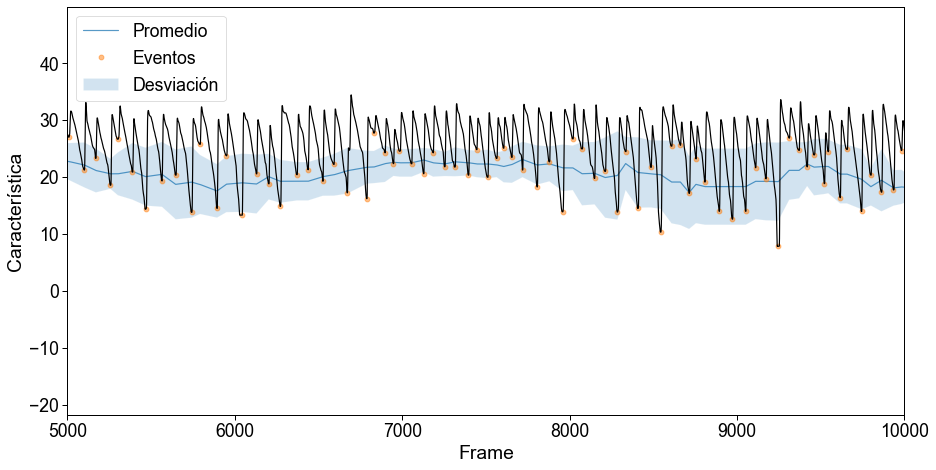

In [3]:
# hindpaw, marker = "left", 0
hindpaw, marker = "right", 1
hindpaw_mask_stats = step_statistics["hindpaw"] == hindpaw
x_key = "y1"
mu = step_statistics[hindpaw_mask_stats]["mu_" + x_key].values
sigma = step_statistics[hindpaw_mask_stats]["sigma_" + x_key].values
t = np.arange(len(mu))
hindpaw_mask_events = step_events["hindpaw"] == hindpaw
x = step_events[hindpaw_mask_events][x_key].values
t_x = step_events[hindpaw_mask_events]["t_" + x_key].values
plt.figure(figsize=(15, 7.5))
plt.plot(t, mu, alpha=0.75, label="Promedio")
plt.fill_between(t, mu - sigma, mu + sigma, alpha=0.2, label="Desviación")
plt.plot(t_x, x, "o", alpha=0.5, label="Eventos")
plt.plot(t, xys[:, marker, 1], "k")
plt.xlim(5e3, 1e4)
plt.xlabel("Frame")
plt.ylabel("Característica")
plt.legend()
plt.show()
plt.close()

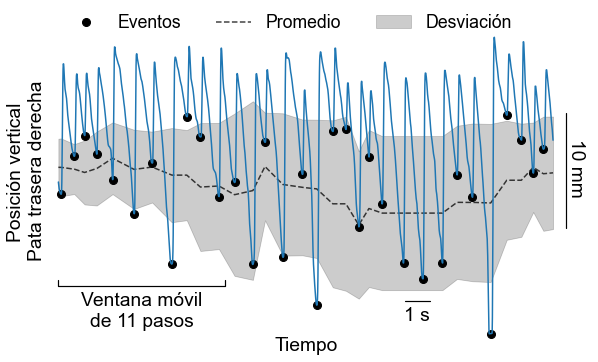

In [4]:
begin, end = 7500, 9500
plt.figure(figsize=(10, 6))
hindpaw, marker = ("right", 1)
hindpaw_mask_stats = step_statistics.query(
    "hindpaw == @hindpaw"
)
x_key = "y1"
mu = hindpaw_mask_stats["mu_" + x_key].values[begin:end]
sigma = hindpaw_mask_stats["sigma_" + x_key].values[begin:end]
t = np.arange(len(mu)) + begin
hindpaw_mask_events = step_events.query(
    "hindpaw == @hindpaw and t_" + x_key + " >= @begin and t_" + x_key + " <= @end"
)
x = hindpaw_mask_events[x_key].values
t_x = hindpaw_mask_events["t_" + x_key].values
plt.plot(t_x, x, "ko", markersize=8, alpha=1, label="Eventos")
plt.plot(t, mu, "k--", alpha=0.75, label="Promedio", lw=1.5)
plt.fill_between(t, mu - sigma, mu + sigma, color="k", alpha=0.2, label="Desviación")
plt.plot(t, xys[begin:end, marker, 1], c="tab:blue", lw=1.5)
# plt.xlim(7.5e3, 8.5e3)
# plt.ylim(-30, 40)
plt.xlabel("Tiempo (s)")
plt.ylabel("Característica")
dx = (end - begin) / 40
plt.text(begin - dx, 22, "Posición vertical    \nPata trasera derecha", va="center", ha="right", rotation=90)
plt.plot([end + dx, end + dx], [17, 27], "k")
plt.text(end + 1.1 * dx, 22, r"10 mm ", va="center", ha="left", rotation=-90)
dy = (32 + 22) / 40
plt.plot([8900, 9000], [10 + 0.5 * dy, 10 + 0.5 * dy], "k")
plt.text(8950, 10 - dy, "1 s", va="bottom", ha="center")
y_pasos = 12
delta_y_pasos = 0.5
plt.plot([7500, 7500, 8175, 8175], [y_pasos + delta_y_pasos, y_pasos, y_pasos, y_pasos + delta_y_pasos], "k")
plt.text((7500 + 8175) * 0.5, y_pasos - delta_y_pasos, "Ventana móvil\nde 11 pasos", va="top", ha="center")
plt.text(8500, 6, "Tiempo", ha="center", va="bottom")
plt.legend(loc=(0.05, 0.95), ncol=3, frameon=False)
plt.gca().set_axis_off()
plt.savefig(config_dodo.FIG_PATH / "Metrics" / "estadistica_de_pasos.pdf", bbox_inches="tight", dpi=600)
plt.show()
plt.close()

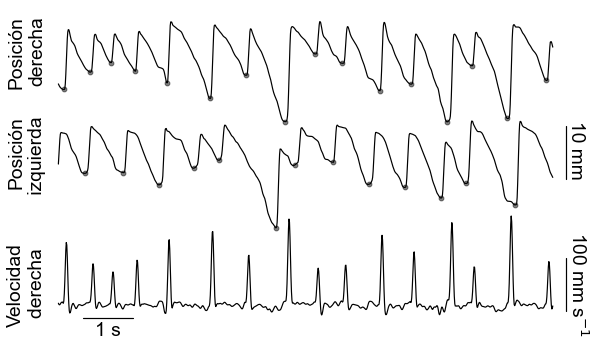

In [5]:
begin, end = 7500, 8500
plt.figure(figsize=(10, 6))
delta = 0
for hindpaw, marker in [("right", 1), ("left", 0)]:
    hindpaw_mask_stats = step_statistics.query(
        "hindpaw == @hindpaw"
    )
    x_key = "y1"
    mu = hindpaw_mask_stats["mu_" + x_key].values[begin:end]
    sigma = hindpaw_mask_stats["sigma_" + x_key].values[begin:end]
    t = np.arange(len(mu)) + begin
    hindpaw_mask_events = step_events.query(
        "hindpaw == @hindpaw and t_" + x_key + " >= @begin and t_" + x_key + " <= @end"
    )
    x = hindpaw_mask_events[x_key].values
    t_x = hindpaw_mask_events["t_" + x_key].values
    plt.plot(t_x, x + delta, "ko", alpha=0.5, label="Eventos")
    plt.plot(t, xys[begin:end, marker, 1] + delta, "k")
    delta -= 20
delta += 20
marker = 1
plt.plot(t, 5 * savgol_filter(xys[begin:end, marker, 1], 11, 3, deriv=1, delta=1.0, axis=-1, mode="nearest") + delta, "k")
# plt.xlim(7.5e3, 8.5e3)
# plt.ylim(-30, 40)
plt.xlabel("Tiempo (s)")
plt.ylabel("Característica")
dx = (end - begin) / 40
plt.text(begin - dx, 27, "Posición\nderecha", va="center", ha="right", rotation=90)
plt.plot([end + dx, end + dx], [3, 13], "k")
plt.text(end + 1.1 * dx, 8.5, r"10 mm", va="center", ha="left", rotation=-90)
plt.text(begin - dx, 7, "Posición\n izquierda", va="center", ha="right", rotation=90)
plt.plot([end + dx, end + dx], [-22, -12], "k")
plt.text(end + 1.1 * dx, -17, r"100 mm s$^{-1}$", va="center", ha="left", rotation=-90)
plt.text(begin - dx, -17, "Velocidad\nderecha ", va="center", ha="right", rotation=90)
dy = (32 + 22) / 40
plt.plot([7550, 7650], [-22 - dy, -22 - dy], "k")
plt.text(7600, -22 - 1.5 * dy, "1 s", va="top", ha="center")
# plt.legend()
# sns.despine(trim=True)
# plt.gca().tick_params(bottom=True, left=True)
plt.gca().set_axis_off()
plt.savefig(config_dodo.FIG_PATH / "Metrics" / "caracteristicas_de_pasos.pdf", bbox_inches="tight", dpi=600)
plt.show()
plt.close()

In [6]:
"""Nombres de las caracteristicas de los pasos"""
X_KEYS = [
    "y1",
    "y2",
    "d2y1",
    "d2y2",
    "dy_max",
    "isi_dy_max",
    "delta_phi",
    "abs_delta_phi",
    "amp",
    "freq",
]

def get_step_statistics_paw_average(step_statistics):
    """Compute average features using both hindpaws."""
    step_statistics_left = step_statistics[step_statistics["hindpaw"] == "left"]
    step_statistics_right = step_statistics[step_statistics["hindpaw"] == "right"]
    step_statistics_paw_avg = pd.DataFrame({})
    for x_key in X_KEYS:
        step_statistics_paw_avg["mu_" + x_key] = (step_statistics_left["mu_" + x_key].values + step_statistics_right["mu_" + x_key].values) * 0.5
        step_statistics_paw_avg["sigma_" + x_key] = np.sqrt(step_statistics_left["sigma_" + x_key].values ** 2 + step_statistics_right["sigma_" + x_key].values ** 2) * 0.5
    return step_statistics_paw_avg

def get_variable_length_array(arrays):
    """Return masked array of variable lengths to compute statistics on."""
    max_len = np.max([len(stats_paw_avg) for stats_paw_avg in arrays])
    xs = np.ma.empty((max_len, len(arrays)))
    xs.mask = True
    for idx, a in enumerate(arrays):
        xs[:len(a), idx] = a
    return xs

def get_step_statistics_variable_length(stats_trial_avg, x_key, mus, sigma2s):
    stats_trial_avg["mu_" + x_key] = get_variable_length_array(mus).mean(axis=-1)
    sigma2s = get_variable_length_array(sigma2s)
    stats_trial_avg["sigma_" + x_key] = np.sqrt(sigma2s.sum(axis=-1)) / sigma2s.count(axis=-1)
    stats_trial_avg["n_trials"] = sigma2s.count(axis=-1)
    return stats_trial_avg

In [7]:
path_stats_paw_avg = config_dodo.MTR_PATH / f"Step/step_statistics_paw_average.pickle"
stats_paw_avg = read_pickle(path_stats_paw_avg)
path_latencies = config_dodo.MTR_PATH / f"Latency/latencies.pickle"
latencies = read_pickle(path_latencies)

In [8]:
X_KEYS.append("excess_freq")

def rotarod_tangential_speed(frame_number):
    return (5.0 + 45.0 * frame_number / 30000.0) * 0.5 * config.ROTAROD_HEIGHT * 2.0 * np.pi / 60.0

def rotarod_frequency(frame_number):
    return (5.0 + 45.0 * frame_number / 30000.0) * 2.0 * np.pi / 60.0

for key in stats_paw_avg.keys():
    frames = np.arange(len(stats_paw_avg[key]["mu_y1"]))
    stats_paw_avg[key]["mu_excess_freq"] = stats_paw_avg[key]["mu_freq"] - rotarod_frequency(frames) * 0.5
    stats_paw_avg[key]["sigma_excess_freq"] = stats_paw_avg[key]["sigma_freq"]

[ 1.37321867e-13  1.91238867e-08 -9.52856860e-04  2.17385858e+01]


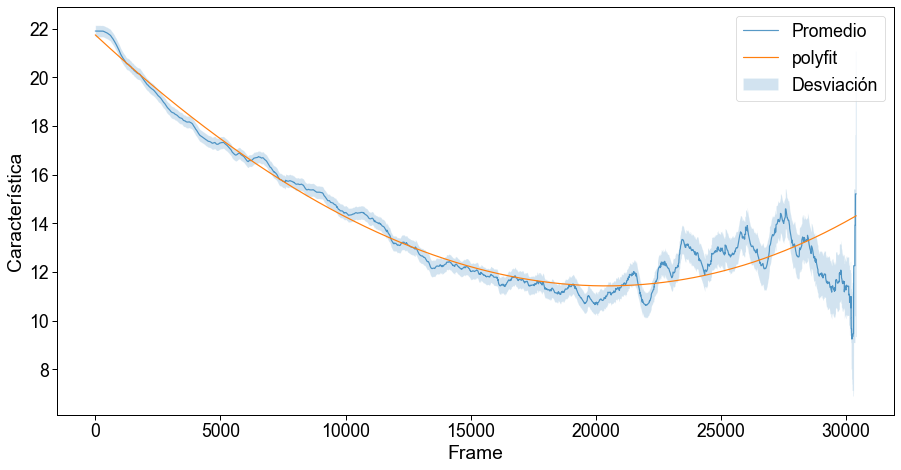

In [9]:
x_key = "y1"
ref = stats_paw_avg[("all", "all", "all")]
mu_ref = ref["mu_" + x_key].values
sigma_ref = ref["sigma_" + x_key].values
t_ref = np.arange(len(mu_ref))

# deg = 0
# deg = 1
# deg = 2
deg = 3
"""fit a deg order polynomial to t_ref mu_ref"""
popt, pcov = curve_fit(lambda x, *p: np.polyval(p, x), t_ref, mu_ref, sigma=sigma_ref, absolute_sigma=True, p0=[1] * (deg + 1))
# popt, pcov = np.polyfit(x=t_ref, y=mu_ref, deg=deg, full=False, cov=True)
print(popt)
"""get errors of parameters from pcov"""
perr = np.sqrt(np.diag(pcov))

plt.figure(figsize=(15, 7.5))
plt.plot(t_ref, mu_ref, alpha=0.75, label="Promedio")
plt.fill_between(t_ref, mu_ref - sigma_ref, mu_ref + sigma_ref, alpha=0.2, label="Desviación")
plt.plot(t_ref, np.polyval(p=popt, x=t_ref), label="polyfit")
plt.xlabel("Frame")
plt.ylabel("Característica")
plt.legend()
plt.show()
plt.close()

In [10]:
mouse_performance_dict = {m: "lp" for m in config_dodo.LP_MOUSE_LIST}
mouse_performance_dict.update({m: "hp" for m in config_dodo.HP_MOUSE_LIST})
latencies["performance"] = latencies["mouse"].map(mouse_performance_dict)
mouse_rendimiento_dict = mouse_performance_dict.copy()
mouse_rendimiento_dict.update({m: "mp" for m in [262, 263, 264]})
latencies["rendimiento"] = latencies["mouse"].map(mouse_rendimiento_dict)
latencies

,mouse,day,trial,latency,performance,rendimiento
0,262,1,1,14793,lp,mp
1,262,1,2,17278,lp,mp
2,262,1,3,20322,lp,mp
3,262,1,4,16625,lp,mp
4,262,1,5,19665,lp,mp
...,...,...,...,...,...,...
245,330,5,1,20606,lp,lp
246,330,5,2,24136,lp,lp
247,330,5,3,23385,lp,lp
248,330,5,4,20705,lp,lp


<AxesSubplot:xlabel='day', ylabel='latency'>

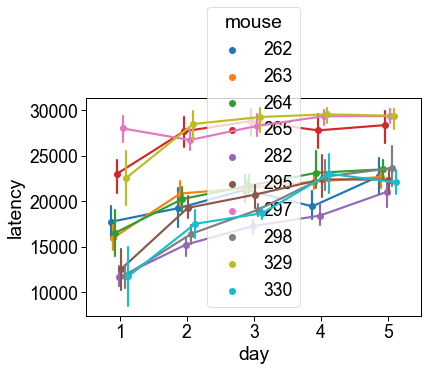

In [11]:
sns.pointplot(x="day", y="latency", data=latencies, hue="mouse", dodge=True)

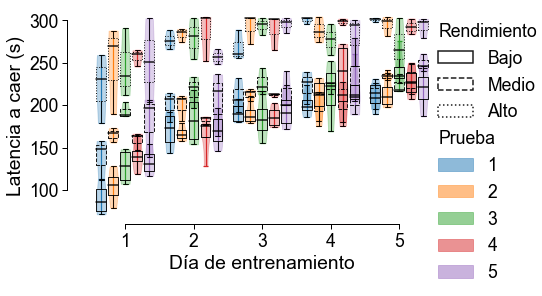

In [12]:
(config_dodo.FIG_PATH / "Latencia").mkdir(parents=True, exist_ok=True)
box_width = 0.8
delta_pos_dias = 1.0
pos_dias = np.arange(1, 6) * delta_pos_dias
delta_pos_trials = 0.175
pos_trials = np.arange(-2, 3) * delta_pos_trials
delta_pos_perf = delta_pos_trials * box_width * 0.0
pos_perf = np.arange(-1, 2) * delta_pos_perf
pos = {(d, t, p): pos_d + pos_t + pos_p for (d, t, p), (pos_d, pos_t, pos_p) in zip(
    product(config_dodo.DAY_LIST, config_dodo.TRIAL_LIST, ["lp", "mp", "hp"]), product(pos_dias, pos_trials, pos_perf)
)}
color_trials = dict(zip(config_dodo.TRIAL_LIST, plt.get_cmap("tab10")(np.linspace(0, 1, len(config_dodo.MOUSE_LIST)))))
ls_perf = {"lp": "-", "mp": "--", "hp": ":"}
fig = plt.figure(figsize=(7, 4))
for d, t, p in product(config_dodo.DAY_LIST, config_dodo.TRIAL_LIST, ["lp", "mp", "hp"]):
    lat = latencies.query("day == @d and trial == @t and rendimiento == @p")["latency"].values
    plt.boxplot(
        positions=[pos[(d, t, p)]], x=lat / 100.0, widths=delta_pos_trials * box_width, showfliers=False,
        boxprops=dict(ls=ls_perf[p], alpha=0.9), medianprops=dict(color="k", lw=1.5, alpha=0.9), capprops=dict(alpha=0.9), whiskerprops=dict(alpha=0.9),
    )
    violin_parts = plt.violinplot(
        positions=[pos[(d, t, p)]], dataset=lat / 100.0, widths=delta_pos_trials * box_width
    )
    for part in violin_parts["bodies"]:
        part.set_facecolor(color_trials[t])
        part.set_edgecolor(color_trials[t])
    violin_parts["cbars"].set_color(color_trials[t])
    violin_parts["cmins"].set_color(color_trials[t])
    violin_parts["cmaxes"].set_color(color_trials[t])
plt.xticks(pos_dias, config_dodo.DAY_LIST)
plt.xlabel("Día de entrenamiento")
plt.ylabel("Latencia a caer (s)")
handles = []
labels = []
title_1 = "Rendimiento"
title_2 = "Prueba"
handles += [Line2D([], [], color="none")]
labels += [title_1]
handles += [mpatches.Patch(fc="white", ec="k", ls=ls_perf[p], lw=1.5, alpha=0.9) for p in ["lp", "mp", "hp"]]
labels += ["Bajo", "Medio", "Alto"]
handles += [Line2D([], [], color="none")]
labels += [title_2]
handles += [mpatches.Patch(color=color_trials[t], alpha=0.5) for t in config_dodo.TRIAL_LIST]
labels += [str(t) for t in config_dodo.TRIAL_LIST]
leg = plt.legend(handles=handles, labels=labels, loc="upper left", bbox_to_anchor=(0.91, 1), frameon=False)
for item, label in zip(leg.legendHandles, leg.texts):
    if label._text in [title_1, title_2]:
        width = item.get_window_extent(fig.canvas.get_renderer()).width
        label.set_ha("left")
        label.set_position((-1.4 * width, 0.0))
leg._legend_handle_box.width = 90.0
sns.despine(trim=True)
plt.savefig(config_dodo.FIG_PATH / "Metrics" / "latencia_por_prueba_por_3_rendimientos.pdf", bbox_inches="tight")
plt.show()
plt.close()

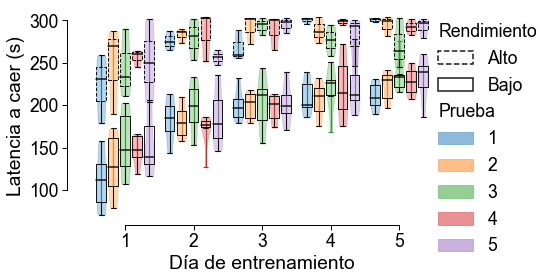

In [11]:
(config_dodo.FIG_PATH / "Latencia").mkdir(parents=True, exist_ok=True)
box_width = 0.8
delta_pos_dias = 1.0
pos_dias = np.arange(1, 6) * delta_pos_dias
delta_pos_trials = 0.175
pos_trials = np.arange(-2, 3) * delta_pos_trials
delta_pos_perf = delta_pos_trials * box_width * 0.0
pos_perf = np.arange(-1, 2, 2) * delta_pos_perf
pos = {(d, t, p): pos_d + pos_t + pos_p for (d, t, p), (pos_d, pos_t, pos_p) in zip(
    product(config_dodo.DAY_LIST, config_dodo.TRIAL_LIST, ["lp", "hp"]), product(pos_dias, pos_trials, pos_perf)
)}
color_trials = dict(zip(config_dodo.TRIAL_LIST, plt.get_cmap("tab10")(np.linspace(0, 1, len(config_dodo.MOUSE_LIST)))))
ls_perf = {"lp": "-", "hp": "--"}
fig = plt.figure(figsize=(7, 4))
for d, t, p in product(config_dodo.DAY_LIST, config_dodo.TRIAL_LIST, ["lp", "hp"]):
    lat = latencies.query("day == @d and trial == @t and performance == @p")["latency"].values
    plt.boxplot(
        positions=[pos[(d, t, p)]], x=lat / 100.0, widths=delta_pos_trials * box_width, showfliers=False,
        boxprops=dict(ls=ls_perf[p], alpha=0.9), medianprops=dict(color="k", lw=1.5, alpha=0.9), capprops=dict(alpha=0.9), whiskerprops=dict(alpha=0.9),
    )
    violin_parts = plt.violinplot(
        positions=[pos[(d, t, p)]], dataset=lat / 100.0, widths=delta_pos_trials * box_width
    )
    for part in violin_parts["bodies"]:
        part.set_facecolor(color_trials[t])
        part.set_edgecolor(color_trials[t])
    violin_parts["cbars"].set_color(color_trials[t])
    violin_parts["cmins"].set_color(color_trials[t])
    violin_parts["cmaxes"].set_color(color_trials[t])
plt.xticks(pos_dias, config_dodo.DAY_LIST)
plt.xlabel("Día de entrenamiento")
plt.ylabel("Latencia a caer (s)")
handles = []
labels = []
title_1 = "Rendimiento"
title_2 = "Prueba"
handles += [Line2D([], [], color="none")]
labels += [title_1]
handles += [mpatches.Patch(fc="white", ec="k", ls=ls_perf[p], lw=1.5, alpha=0.9) for p in ["hp", "lp"]]
labels += ["Alto", "Bajo"]
handles += [Line2D([], [], color="none")]
labels += [title_2]
handles += [mpatches.Patch(color=color_trials[t], alpha=0.5) for t in config_dodo.TRIAL_LIST]
labels += [str(t) for t in config_dodo.TRIAL_LIST]
leg = plt.legend(handles=handles, labels=labels, loc="upper left", bbox_to_anchor=(0.91, 1), frameon=False)
for item, label in zip(leg.legendHandles, leg.texts):
    if label._text in [title_1, title_2]:
        width = item.get_window_extent(fig.canvas.get_renderer()).width
        label.set_ha("left")
        label.set_position((-1.4 * width, 0.0))
leg._legend_handle_box.width = 90.0
sns.despine(trim=True)
plt.savefig(config_dodo.FIG_PATH / "Metrics" / "latencia_por_prueba_por_rendimiento.pdf", bbox_inches="tight")
plt.show()
plt.close()

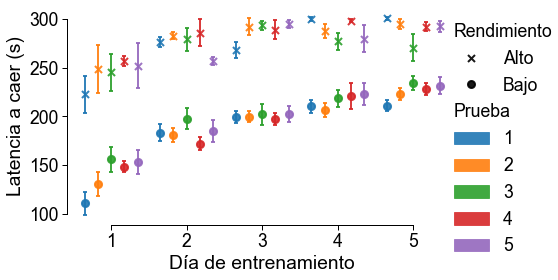

In [15]:
(config_dodo.FIG_PATH / "Latencia").mkdir(parents=True, exist_ok=True)
box_width = 0.8
delta_pos_dias = 1.0
pos_dias = np.arange(1, 6) * delta_pos_dias
delta_pos_trials = 0.175
pos_trials = np.arange(-2, 3) * delta_pos_trials
# delta_pos_perf = delta_pos_trials * box_width * 0.2
delta_pos_perf = delta_pos_trials * box_width * 0.0
pos_perf = np.arange(-1, 2, 2) * delta_pos_perf
pos = {(d, t, p): pos_d + pos_t + pos_p for (d, t, p), (pos_d, pos_t, pos_p) in zip(
    product(config_dodo.DAY_LIST, config_dodo.TRIAL_LIST, ["lp", "hp"]), product(pos_dias, pos_trials, pos_perf)
)}
color_trials = dict(zip(config_dodo.TRIAL_LIST, plt.get_cmap("tab10")(np.linspace(0, 1, len(config_dodo.MOUSE_LIST)))))
ls_perf = {"lp": "-", "hp": "--"}
marker_perf = {"lp": "o", "hp": "x"}
fig = plt.figure(figsize=(7, 4))
for d, t, p in product(config_dodo.DAY_LIST, config_dodo.TRIAL_LIST, ["lp", "hp"]):
    lat = latencies.query("day == @d and trial == @t and performance == @p")["latency"].values
    lat = lat / 100.0
    mean = np.mean(lat)
    error = np.std(lat) / np.sqrt(len(lat)) # SEM
    # error = np.std(lat) # STD
    plt.scatter(
        x=[pos[(d, t, p)]], y=mean, marker=marker_perf[p], color=color_trials[t], s=50, linewidths=2, alpha=0.9
    )
    plt.errorbar(
        x=[pos[(d, t, p)]], y=mean, yerr=error, ecolor=color_trials[t], capsize=2, elinewidth=2, capthick=2, alpha=0.9
    )
    # plt.boxplot(
    #     positions=[pos[(d, t, p)]], x=met, widths=delta_pos_trials * box_width, showfliers=False,
    #     boxprops=dict(ls=ls_perf[p], alpha=0.9), medianprops={"color": "k", "lw": 1.5},
    # )
    # violin_parts = plt.violinplot(
    #     positions=[pos[(d, t, p)]], dataset=met, widths=delta_pos_trials * box_width
    # )
    # for part in violin_parts["bodies"]:
    #     part.set_facecolor(color_trials[t])
    #     part.set_edgecolor(color_trials[t])
    # violin_parts["cbars"].set_color(color_trials[t])
    # violin_parts["cmins"].set_color(color_trials[t])
    # violin_parts["cmaxes"].set_color(color_trials[t])
plt.xticks(pos_dias, config_dodo.DAY_LIST)
plt.xlabel("Día de entrenamiento")
plt.ylabel("Latencia a caer (s)")
handles = []
labels = []
title_1 = "Rendimiento"
title_2 = "Prueba"
handles += [Line2D([], [], color="none")]
labels += [title_1]
handles += [Line2D([], [], marker=marker_perf[p], markersize=7, markeredgewidth=2, lw=2, ls="", c="k", alpha=0.9) for p in ["hp", "lp"]]
labels += ["Alto", "Bajo"]
handles += [Line2D([], [], color="none")]
labels += [title_2]
# handles += [mpatches.Patch(color=color_trials[t], alpha=0.5) for t in config_dodo.TRIAL_LIST]
handles += [mpatches.Patch(color=color_trials[t], alpha=0.9) for t in config_dodo.TRIAL_LIST]
labels += [str(t) for t in config_dodo.TRIAL_LIST]
# leg = plt.legend(handles=handles, labels=labels, loc="upper left", bbox_to_anchor=(0.91, 1), frameon=False)
leg = plt.legend(handles=handles, labels=labels, loc="upper left", bbox_to_anchor=(0.95, 1), frameon=False)
for item, label in zip(leg.legendHandles, leg.texts):
    if label._text in [title_1, title_2]:
        width = item.get_window_extent(fig.canvas.get_renderer()).width
        label.set_ha("left")
        label.set_position((-1.4 * width, 0.0))
leg._legend_handle_box.width = 90.0
sns.despine(trim=True)
plt.savefig(config_dodo.FIG_PATH / "Metrics" / "latencia_por_prueba_por_rendimiento.pdf", bbox_inches="tight")
plt.show()
plt.close()

In [13]:
def my_poly(x, *p):
    """my polynomial function, change order of parameters to a more natural one"""
    return np.polyval(p[::-1], x)

def fit_poly(deg, t, mu, sigma):
    """fit a deg order polynomial to t_ref mu_ref"""
    popt, pcov = curve_fit(my_poly, t, mu, sigma=sigma, absolute_sigma=True, p0=[1] * (deg + 1))
    """get errors of parameters from pcov"""
    perr = np.sqrt(np.diag(pcov))
    return {"popt": popt, "perr": perr}

metricas = latencies.copy().drop(columns=["latency"])
ajustes_lineales = {}
ajustes_polys = {}
# t_max = 30000 # Primeros 300 s
# t_max = 20000 # Primeros 200 s
# t_max = 15000 # Primeros 150 s
t_max = 10000 # Primeros 100 s
# t_max = 5000 # Primeros 50 s
t_0 = 0 # Desde 0 s
# t_0 = 5000 # Desde 50 s
# t_0 = 10000 # Desde 100 s
# t_0 = 15000 # Desde 150 s
# t_0 = 25000 # Desde 250 s
for x_key in X_KEYS:
    metricas["zscore_ref_" + x_key] = np.nan
    metricas["avg_ref_" + x_key] = np.nan
    metricas["std_ref_" + x_key] = np.nan
    metricas["avg_" + x_key] = np.nan
    metricas["precision_" + x_key] = np.nan
    metricas["exactitud_" + x_key] = np.nan
    metricas["rmse_" + x_key] = np.nan
    metricas["linear_a0_" + x_key] = np.nan
    metricas["linear_a1_" + x_key] = np.nan
    metricas["poly_a0_" + x_key] = np.nan
    metricas["poly_a1_" + x_key] = np.nan
    metricas["poly_a2_" + x_key] = np.nan
    metricas["poly_a3_" + x_key] = np.nan
    ref = stats_paw_avg[("all", "all", "all")]
    mu_ref = ref["mu_" + x_key].values
    sigma_ref = ref["sigma_" + x_key].values
    for (m, d, t) in config_dodo.KEY_LIST:
        t_compare = np.minimum(t_max, stats_paw_avg[(m, d, t)].shape[0])
        mu = stats_paw_avg[(m, d, t)]["mu_" + x_key].values[t_0:t_compare]
        sigma = stats_paw_avg[(m, d, t)]["sigma_" + x_key].values[t_0:t_compare]
        i = metricas.query("mouse == @m and day == @d and trial == @t").index
        # metricas.loc[i, "zscore_ref_" + x_key] = np.mean((mu - mu_ref[t_0:t_compare]) / np.sqrt(sigma ** 2 + sigma_ref[t_0:t_compare] ** 2))
        metricas.loc[i, "zscore_ref_" + x_key] = trim_mean((mu - mu_ref[t_0:t_compare]) / np.sqrt(sigma ** 2 + sigma_ref[t_0:t_compare] ** 2), 0.1)
        # metricas.loc[i, "avg_ref_" + x_key] = np.mean(mu - mu_ref[t_0:t_compare])
        metricas.loc[i, "avg_ref_" + x_key] = trim_mean(mu - mu_ref[t_0:t_compare], 0.1)
        # metricas.loc[i, "std_ref_" + x_key] = np.std(mu - mu_ref[t_0:t_compare])
        metricas.loc[i, "std_ref_" + x_key] = trim_mean(np.abs(mu - mu_ref[t_0:t_compare]), 0.1) / norm.ppf(0.75)
        # metricas.loc[i, "avg_" + x_key] = np.mean(mu)
        metricas.loc[i, "avg_" + x_key] = trim_mean(mu, 0.1)
        # metricas.loc[i, "precision_" + x_key] = np.sqrt(np.mean(sigma ** 2))
        metricas.loc[i, "precision_" + x_key] = np.sqrt(trim_mean(sigma ** 2, 0.1))
        times = np.arange(t_0, t_compare)
        linear_fit = fit_poly(deg=1, t=times, mu=mu, sigma=sigma)
        ajustes_lineales[(m, d, t)] = linear_fit
        metricas.loc[i, "linear_a0_" + x_key] = linear_fit["popt"][0]
        metricas.loc[i, "linear_a1_" + x_key] = linear_fit["popt"][1]
        poly_fit = fit_poly(deg=3, t=times, mu=mu, sigma=sigma)
        ajustes_polys[(m, d, t)] = poly_fit
        metricas.loc[i, "poly_a0_" + x_key] = poly_fit["popt"][0]
        metricas.loc[i, "poly_a1_" + x_key] = poly_fit["popt"][1]
        metricas.loc[i, "poly_a2_" + x_key] = poly_fit["popt"][2]
        metricas.loc[i, "poly_a3_" + x_key] = poly_fit["popt"][3]
        mu_fit = my_poly(times, *poly_fit["popt"])
        # metricas.loc[i, "exactitud_" + x_key] = np.sqrt(np.mean((mu - mu_fit) ** 2))
        metricas.loc[i, "exactitud_" + x_key] = np.sqrt(trim_mean((mu - mu_fit) ** 2, 0.1))
        # metricas.loc[i, "rmse_" + x_key] = np.sqrt(np.mean((mu - mu_fit) ** 2 + sigma ** 2))
        metricas.loc[i, "rmse_" + x_key] = np.sqrt(trim_mean((mu - mu_fit) ** 2 + sigma ** 2, 0.1))

In [14]:
metricas

,mouse,day,trial,performance,rendimiento,zscore_ref_y1,avg_ref_y1,std_ref_y1,avg_y1,precision_y1,...,avg_excess_freq,precision_excess_freq,exactitud_excess_freq,rmse_excess_freq,linear_a0_excess_freq,linear_a1_excess_freq,poly_a0_excess_freq,poly_a1_excess_freq,poly_a2_excess_freq,poly_a3_excess_freq
0,262,1,1,lp,mp,-0.076944,-0.428741,2.558885,16.971594,4.996586,...,0.880681,0.565845,0.183286,0.594042,0.819504,-0.000002,1.361626,-0.000458,9.732328e-08,-5.896836e-12
1,262,1,2,lp,mp,1.192709,3.856059,5.970537,21.462258,3.625123,...,1.108759,0.632604,0.301586,0.707789,0.926683,-0.000004,1.553302,-0.000461,8.581791e-08,-4.562854e-12
2,262,1,3,lp,mp,1.700848,4.910137,7.279780,22.475227,2.985497,...,0.855118,0.386335,0.114832,0.404380,0.940904,-0.000026,1.301238,-0.000306,5.785131e-08,-3.445359e-12
3,262,1,4,lp,mp,1.516519,3.746708,5.554878,21.617778,2.682082,...,0.685162,0.302071,0.118222,0.335324,0.526745,0.000024,0.866225,-0.000263,6.359006e-08,-3.910949e-12
4,262,1,5,lp,mp,1.317801,2.984814,4.425292,20.576637,2.335771,...,0.650660,0.262213,0.086567,0.284218,0.546869,0.000015,0.660284,-0.000106,3.084234e-08,-2.099502e-12
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
245,330,5,1,lp,lp,1.253322,4.088770,6.062020,21.732799,3.560698,...,0.606501,0.377019,0.108606,0.394224,0.691428,-0.000032,0.663176,0.000061,-3.147552e-08,2.532758e-12
246,330,5,2,lp,lp,1.319132,2.952432,4.619348,20.797736,2.706642,...,0.430149,0.243681,0.105259,0.266935,0.360874,0.000009,0.380086,0.000011,-5.587502e-09,6.656989e-13
247,330,5,3,lp,lp,1.361519,4.005848,5.939079,21.620773,3.152415,...,0.493355,0.274662,0.076608,0.286698,0.570938,-0.000024,0.931004,-0.000291,5.154544e-08,-2.885640e-12
248,330,5,4,lp,lp,1.381627,4.340274,6.434900,21.924538,3.258410,...,0.487824,0.309264,0.092971,0.324363,0.553027,-0.000018,0.574400,0.000001,-1.218035e-08,1.134726e-12


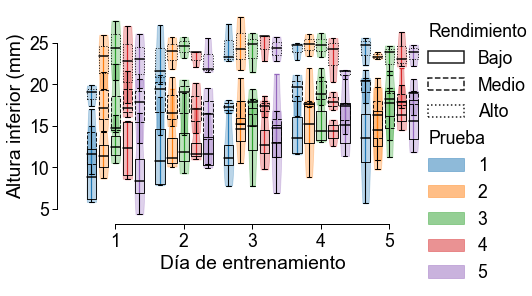

In [16]:
(config_dodo.FIG_PATH / "Latencia").mkdir(parents=True, exist_ok=True)
box_width = 0.8
delta_pos_dias = 1.0
pos_dias = np.arange(1, 6) * delta_pos_dias
delta_pos_trials = 0.175
pos_trials = np.arange(-2, 3) * delta_pos_trials
delta_pos_perf = delta_pos_trials * box_width * 0.0
pos_perf = np.arange(-1, 2) * delta_pos_perf
pos = {(d, t, p): pos_d + pos_t + pos_p for (d, t, p), (pos_d, pos_t, pos_p) in zip(
    product(config_dodo.DAY_LIST, config_dodo.TRIAL_LIST, ["lp", "mp", "hp"]), product(pos_dias, pos_trials, pos_perf)
)}
color_trials = dict(zip(config_dodo.TRIAL_LIST, plt.get_cmap("tab10")(np.linspace(0, 1, len(config_dodo.MOUSE_LIST)))))
ls_perf = {"lp": "-", "mp": "--", "hp": ":"}
fig = plt.figure(figsize=(7, 4))
for d, t, p in product(config_dodo.DAY_LIST, config_dodo.TRIAL_LIST, ["lp", "mp", "hp"]):
    # met = metricas.query("day == @d and trial == @t and rendimiento == @p")["avg_ref_" + "y1"].values
    # met = metricas.query("day == @d and trial == @t and rendimiento == @p")["std_ref_" + "y1"].values
    # met = metricas.query("day == @d and trial == @t and rendimiento == @p")["zscore_ref_" + "y1"].values
    met = metricas.query("day == @d and trial == @t and rendimiento == @p")["avg_" + "y1"].values
    # met = metricas.query("day == @d and trial == @t and rendimiento == @p")["precision_" + "y1"].values
    # met = metricas.query("day == @d and trial == @t and rendimiento == @p")["rmse_" + "y1"].values
    plt.boxplot(
        positions=[pos[(d, t, p)]], x=met, widths=delta_pos_trials * box_width, showfliers=False,
        boxprops=dict(ls=ls_perf[p], alpha=0.9), medianprops={"color": "k", "lw": 1.5},
    )
    violin_parts = plt.violinplot(
        positions=[pos[(d, t, p)]], dataset=met, widths=delta_pos_trials * box_width
    )
    for part in violin_parts["bodies"]:
        part.set_facecolor(color_trials[t])
        part.set_edgecolor(color_trials[t])
    violin_parts["cbars"].set_color(color_trials[t])
    violin_parts["cmins"].set_color(color_trials[t])
    violin_parts["cmaxes"].set_color(color_trials[t])
plt.xticks(pos_dias, config_dodo.DAY_LIST)
plt.xlabel("Día de entrenamiento")
plt.ylabel("Altura inferior (mm)")
handles = []
labels = []
title_1 = "Rendimiento"
title_2 = "Prueba"
handles += [Line2D([], [], color="none")]
labels += [title_1]
handles += [mpatches.Patch(fc="white", ec="k", ls=ls_perf[p], lw=1.5, alpha=0.9) for p in ["lp", "mp", "hp"]]
labels += ["Bajo", "Medio", "Alto"]
handles += [Line2D([], [], color="none")]
labels += [title_2]
handles += [mpatches.Patch(color=color_trials[t], alpha=0.5) for t in config_dodo.TRIAL_LIST]
labels += [str(t) for t in config_dodo.TRIAL_LIST]
leg = plt.legend(handles=handles, labels=labels, loc="upper left", bbox_to_anchor=(0.91, 1), frameon=False)
for item, label in zip(leg.legendHandles, leg.texts):
    if label._text in [title_1, title_2]:
        width = item.get_window_extent(fig.canvas.get_renderer()).width
        label.set_ha("left")
        label.set_position((-1.4 * width, 0.0))
leg._legend_handle_box.width = 90.0
sns.despine(trim=True)
plt.savefig(config_dodo.FIG_PATH / "Metrics" / "altura_inferior_por_prueba_por_3_rendimientos.pdf", bbox_inches="tight")
plt.show()
plt.close()

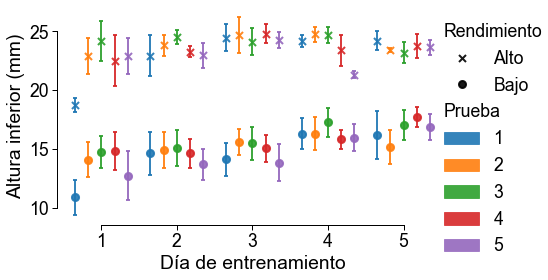

In [17]:
(config_dodo.FIG_PATH / "Latencia").mkdir(parents=True, exist_ok=True)
box_width = 0.8
delta_pos_dias = 1.0
pos_dias = np.arange(1, 6) * delta_pos_dias
delta_pos_trials = 0.175
pos_trials = np.arange(-2, 3) * delta_pos_trials
# delta_pos_perf = delta_pos_trials * box_width * 0.2
delta_pos_perf = delta_pos_trials * box_width * 0.0
pos_perf = np.arange(-1, 2, 2) * delta_pos_perf
pos = {(d, t, p): pos_d + pos_t + pos_p for (d, t, p), (pos_d, pos_t, pos_p) in zip(
    product(config_dodo.DAY_LIST, config_dodo.TRIAL_LIST, ["lp", "hp"]), product(pos_dias, pos_trials, pos_perf)
)}
color_trials = dict(zip(config_dodo.TRIAL_LIST, plt.get_cmap("tab10")(np.linspace(0, 1, len(config_dodo.MOUSE_LIST)))))
ls_perf = {"lp": "-", "hp": "--"}
marker_perf = {"lp": "o", "hp": "x"}
fig = plt.figure(figsize=(7, 4))
for d, t, p in product(config_dodo.DAY_LIST, config_dodo.TRIAL_LIST, ["lp", "hp"]):
    # met = metricas.query("day == @d and trial == @t and performance == @p")["avg_ref_" + "y1"].values
    # met = metricas.query("day == @d and trial == @t and performance == @p")["std_ref_" + "y1"].values
    # met = metricas.query("day == @d and trial == @t and performance == @p")["zscore_ref_" + "y1"].values
    met = metricas.query("day == @d and trial == @t and performance == @p")["avg_" + "y1"].values
    # met = metricas.query("day == @d and trial == @t and performance == @p")["precision_" + "y1"].values
    # met = metricas.query("day == @d and trial == @t and performance == @p")["rmse_" + "y1"].values
    """plot mean of met with standard error of the mean as error bars"""
    mean = np.mean(met)
    error = np.std(met) / np.sqrt(len(met)) # SEM
    # error = np.std(met) # STD
    plt.scatter(
        x=[pos[(d, t, p)]], y=mean, marker=marker_perf[p], color=color_trials[t], s=50, linewidths=2, alpha=0.9
    )
    plt.errorbar(
        x=[pos[(d, t, p)]], y=mean, yerr=error, ecolor=color_trials[t], capsize=2, elinewidth=2, capthick=2, alpha=0.9
    )
    # plt.boxplot(
    #     positions=[pos[(d, t, p)]], x=met, widths=delta_pos_trials * box_width, showfliers=False,
    #     boxprops=dict(ls=ls_perf[p], alpha=0.9), medianprops={"color": "k", "lw": 1.5},
    # )
    # violin_parts = plt.violinplot(
    #     positions=[pos[(d, t, p)]], dataset=met, widths=delta_pos_trials * box_width
    # )
    # for part in violin_parts["bodies"]:
    #     part.set_facecolor(color_trials[t])
    #     part.set_edgecolor(color_trials[t])
    # violin_parts["cbars"].set_color(color_trials[t])
    # violin_parts["cmins"].set_color(color_trials[t])
    # violin_parts["cmaxes"].set_color(color_trials[t])
plt.xticks(pos_dias, config_dodo.DAY_LIST)
plt.xlabel("Día de entrenamiento")
plt.ylabel("Altura inferior (mm)")
handles = []
labels = []
title_1 = "Rendimiento"
title_2 = "Prueba"
handles += [Line2D([], [], color="none")]
labels += [title_1]
handles += [Line2D([], [], marker=marker_perf[p], markersize=7, markeredgewidth=2, lw=2, ls="", c="k", alpha=0.9) for p in ["hp", "lp"]]
labels += ["Alto", "Bajo"]
handles += [Line2D([], [], color="none")]
labels += [title_2]
# handles += [mpatches.Patch(color=color_trials[t], alpha=0.5) for t in config_dodo.TRIAL_LIST]
handles += [mpatches.Patch(color=color_trials[t], alpha=0.9) for t in config_dodo.TRIAL_LIST]
labels += [str(t) for t in config_dodo.TRIAL_LIST]
# leg = plt.legend(handles=handles, labels=labels, loc="upper left", bbox_to_anchor=(0.91, 1), frameon=False)
leg = plt.legend(handles=handles, labels=labels, loc="upper left", bbox_to_anchor=(0.95, 1), frameon=False)
for item, label in zip(leg.legendHandles, leg.texts):
    if label._text in [title_1, title_2]:
        width = item.get_window_extent(fig.canvas.get_renderer()).width
        label.set_ha("left")
        label.set_position((-1.4 * width, 0.0))
leg._legend_handle_box.width = 90.0
sns.despine(trim=True)
plt.savefig(config_dodo.FIG_PATH / "Metrics" / "altura_inferior_por_prueba_por_rendimiento.pdf", bbox_inches="tight")
plt.show()
plt.close()

In [40]:
pvalue = 0.55
ptext = "P=" + f"{pvalue:.2f}"
# supertext = "^" + "^".join(ptext[i:i + 1] for i in range(len(ptext)))
supertext = "^{" + ptext + "}"
text = rf"${supertext}$"
text

'$^{P=0.55}$'

ANOVA
hp 1.2337538423276008e-06
lp 1.1183939191043236e-30
Paired t-test
D1 3.297167783184595e-05
D2 0.0002581178213364829
D3 4.7140702042344166e-05
D4 0.0003737853302572739
D5 0.0017126424078461066


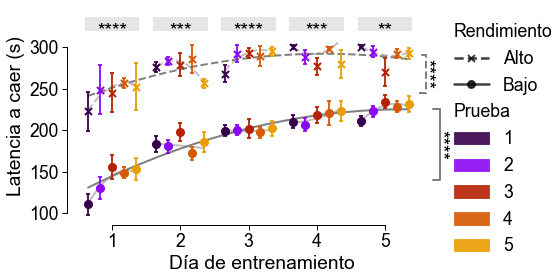

In [16]:
from scipy.stats import f_oneway, ttest_rel

def pvalue_to_stars(pvalue):
    """Format pvalue into stars or ns"""
    text = ""
    if pvalue <= 0.05:
        text += "*"
        if pvalue <= 0.01:
            text += "*"
            if pvalue <= 0.001:
                text += "*"
                if pvalue <= 0.0001:
                    text += "*"
    else:
        # text = r"$^{\mathrm{NS}}$"
        text = r"$^{\mathrm{ns}}$"
        # ptext = "P=" + f"{pvalue:.2f}"
        # if pvalue < 0.1:
        #     ptext = "P=" + f"{pvalue:.2f}"[1:]
        # else:
        #     ptext = "P=" + f"{pvalue:.1f}"[1:]
        # supertext = "^{" + ptext + "}"
        # text = rf"${supertext}$"
    return text

def plot_pvalue_vertical(ax, pvalue, x, ylims, w, ls, lw, c, alpha):
    """annotate pvalue"""
    text = pvalue_to_stars(pvalue)
    ymin, ymax = ylims
    ax.plot([x, x + w, x + w, x], [ymin, ymin, ymax, ymax], ls=ls, lw=lw, c=c, alpha=alpha)
    ax.annotate(text=text, xy=(x + w, 0.5 * (ymin + ymax)), zorder=10, ha="center", va="center", rotation=-90)

def plot_pvalue_horizontal(ax, pvalue, y, xlims, h, c, alpha):
    """annotate pvalue"""
    text = pvalue_to_stars(pvalue)
    xmin, xmax = xlims
    rect = mpatches.Rectangle((xmin, y), xmax - xmin, h, linewidth=0.0, edgecolor="none", facecolor=c, alpha=alpha)
    ax.add_patch(rect)
    ax.annotate(text=text, xy=(0.5 * (xmin + xmax), y), zorder=10, ha="center", va="center")

def my_poly(x, *p):
    """my polynomial function, change order of parameters to a more natural one"""
    return np.polyval(p[::-1], x)

def my_poly_plot(x, *p):
    """my polynomial function to plot, change order of parameters to a more natural one"""
    return np.polyval(p[::-1], x)

def fit_poly_plot(deg, t, mu, sigma):
    """fit a deg order polynomial to t_ref mu_ref"""
    popt, _ = curve_fit(my_poly, t, mu, sigma=sigma, absolute_sigma=True, p0=[1] * (deg + 1))
    return popt

box_width = 0.8
delta_pos_dias = 1.0
pos_dias = np.arange(1, 6) * delta_pos_dias
delta_pos_trials = 0.175
pos_trials = np.arange(-2, 3) * delta_pos_trials
pos = [pos_d + pos_t for pos_d, pos_t in product(pos_dias, pos_trials)]
# color_trials = plt.get_cmap("tab10")(np.tile(np.linspace(0, 1, 10)[:len(config_dodo.TRIAL_LIST)], len(config_dodo.DAY_LIST)))
color_trials = plt.get_cmap("gnuplot")([0.05, 0.3, 0.5, 0.7, 0.85], len(config_dodo.DAY_LIST))
ls_perf = {"lp": "-", "hp": "--"}
marker_perf = {"lp": "o", "hp": "x"}

metricas_grupos_intertrial = latencies.groupby(["performance", "day", "trial"])
mean = metricas_grupos_intertrial.mean()
error = metricas_grupos_intertrial.sem()
metricas_grupos_interdia = latencies.groupby(["performance", "day"])
mean_interdia = metricas_grupos_interdia.mean()
error_interdia = metricas_grupos_interdia.sem()
(config_dodo.FIG_PATH / "Latencia").mkdir(parents=True, exist_ok=True)

fig = plt.figure(figsize=(7, 4))
for t, p in product(config_dodo.TRIAL_LIST, ["lp", "hp"]):
    i = t - 1
    values = mean.query("trial == @t and performance == @p")["latency"].values / 100.0
    bars = error.query("trial == @t and performance == @p")["latency"].values / 100.0
    plt.scatter(
        x=pos[i::5], y=values,
        marker=marker_perf[p], color=color_trials[i], s=50, linewidths=2, alpha=1.0, zorder=10
    )
    plt.errorbar(
        x=pos[i::5], y=values, yerr=bars,
        color="none", ecolor=color_trials[i], capsize=2, elinewidth=2, capthick=2, alpha=0.9, zorder=10
    )
for p in ["lp", "hp"]:
    values_interdia = mean_interdia.query("performance == @p")["latency"].values / 100.0
    bars_interdia = error_interdia.query("performance == @p")["latency"].values / 100.0
    popt = fit_poly_plot(deg=2, t=pos_dias, mu=values_interdia, sigma=bars_interdia)
    plt.plot(pos, my_poly_plot(pos, *popt), color="k", linewidth=2, alpha=0.5, ls=ls_perf[p], zorder=0)
    for d in config_dodo.DAY_LIST:
        values = mean.query("day == @d and performance == @p")["latency"].values / 100.0
        bars = error.query("day == @d and performance == @p")["latency"].values / 100.0
        pos_d = d + pos_trials
        popt = fit_poly_plot(deg=2, t=pos_d, mu=values, sigma=bars)
        pos_d = np.linspace(pos_d[0], pos_d[-1], 16)
        plt.plot(pos_d, my_poly_plot(pos_d, *popt), color="0.5", linewidth=2, alpha=0.5, ls=ls_perf[p], zorder=0)

"""Perform one way ANOVA over lat using day and trial as categories and latency as dependent variable"""
ax = plt.gca()
xlims = ax.get_xlim()
ylims = ax.get_ylim()
print("ANOVA")
dx = 0.0
for p in ["hp", "lp"]:
    # stat, pvalue = f_oneway(*[latencies.query("day == @d and trial == @t and performance == @p")["latency"].values / 100.0 for (d, t) in product(config_dodo.DAY_LIST, config_dodo.TRIAL_LIST)])
    stat, pvalue = f_oneway(*[latencies.query("day == @d and performance == @p")["latency"].values / 100.0 for d in config_dodo.DAY_LIST])
    plot_pvalue_vertical(
        ax=ax, pvalue=pvalue, x=5.5 + dx,
        ylims=(mean_interdia.query("performance == @p")["latency"].min() / 100.0, mean_interdia.query("performance == @p")["latency"].max()  / 100.0),
        w=0.1, ls=ls_perf[p], lw=2, c="k", alpha=0.5,
    )
    dx += 0.2
    print(p, pvalue)
"""Perform paired t-test over lat for each day, pairing the means from lp and hp for each trial"""
print("Paired t-test")
for d in config_dodo.DAY_LIST:
    stat, pvalue = ttest_rel(*[mean.query("day == @d and performance == @p")["latency"].values / 100.0 for p in ["lp", "hp"]])
    plot_pvalue_horizontal(
        ax=ax, pvalue=pvalue, y=ylims[1],
        xlims=(d - 0.4, d + 0.4),
        h=(ylims[1] - ylims[0]) * 0.075, c="0.5", alpha=0.2,
    )
    print(f"D{d}", pvalue)

plt.xticks(pos_dias, config_dodo.DAY_LIST)
plt.xlabel("Día de entrenamiento")
plt.ylabel("Latencia a caer (s)")
handles = []
labels = []
title_1 = "Rendimiento"
title_2 = "Prueba"
handles += [Line2D([], [], color="none")]
labels += [title_1]
handles += [Line2D([], [], marker=marker_perf[p], markersize=7, markeredgewidth=2, lw=2.5, ls=ls_perf[p], c="k", alpha=0.75) for p in ["hp", "lp"]]
labels += ["Alto", "Bajo"]
handles += [Line2D([], [], color="none")]
labels += [title_2]
# handles += [mpatches.Patch(color=c, alpha=0.5) for c in color_trials]
handles += [mpatches.Patch(color=c, alpha=0.9) for c in color_trials]
labels += [str(t) for t in config_dodo.TRIAL_LIST]
# leg = plt.legend(handles=handles, labels=labels, loc="upper left", bbox_to_anchor=(0.91, 1), frameon=False)
leg = plt.legend(handles=handles, labels=labels, loc="upper left", bbox_to_anchor=(0.95, 1), frameon=False)
for item, label in zip(leg.legendHandles, leg.texts):
    if label._text in [title_1, title_2]:
        width = item.get_window_extent(fig.canvas.get_renderer()).width
        label.set_ha("left")
        label.set_position((-1.4 * width, 0.0))
leg._legend_handle_box.width = 90.0
sns.despine(trim=True)
plt.savefig(config_dodo.FIG_PATH / "Metrics" / "latencia_por_prueba_por_rendimiento.pdf", bbox_inches="tight")
plt.show()
plt.close()

In [20]:
def my_poly_plot(x, *p):
    """my polynomial function to plot, change order of parameters to a more natural one"""
    return np.polyval(p[::-1], x)

def fit_poly_plot(deg, t, mu, sigma):
    """fit a deg order polynomial to t_ref mu_ref"""
    popt, _ = curve_fit(my_poly, t, mu, sigma=sigma, absolute_sigma=True, p0=[1] * (deg + 1))
    return popt

METRIC_KEYS = [
    # "zscore_ref_",
    # "avg_ref_",
    # "std_ref_",
    "avg_",
    # "precision_",
    # "exactitud_",
    "rmse_",
    # "linear_a0_",
    "linear_a1_",
    # "poly_a0_",
    # "poly_a1_",
    # "poly_a2_",
    # "poly_a3_",
]

METRIC_KEY_NAMES = {
    "zscore_ref_": " (Z-score)",
    "avg_ref_": "",
    "std_ref_": "",
    "avg_": "Promedio",
    "precision_": "Precisión",
    "exactitud_": "Exactitud",
    "rmse_": "RMSE",
    "linear_a0_": "Ordenada",
    "linear_a1_": "Pendiente",
    "poly_a0_": r" ($a_0$)",
    "poly_a1_": r" ($a_1$)",
    "poly_a2_": r" ($a_2$)",
    "poly_a3_": r" ($a_3$)",
}

X_KEY_NAMES = {
    "y1": "Altura mínima",
    "y2": "Altura máxima",
    "d2y1": "Aceleración en altura mínima",
    "d2y2": "Aceleración en altura máxima",
    "dy_max": "Velocidad",
    "isi_dy_max": "ISI",
    "delta_phi": "Desfasaje",
    "abs_delta_phi": "Desfasaje",
    "amp": "Amplitud",
    "freq": "Frecuencia",
    "excess_freq": "Exceso de frecuencia",
}

X_KEY_UNITS = {
    "y1": " (mm)",
    "y2": " (mm)",
    "d2y1": r" (mm s$^{-2}$)",
    "d2y2": r" (mm s$^{-2}$)",
    "dy_max": r" (mm s$^{-1}$)",
    "isi_dy_max": " (s)",
    "delta_phi": " (vueltas)",
    "abs_delta_phi": " (vueltas)",
    "amp": " (mm)",
    "freq": " (Hz)",
    "excess_freq": " (Hz)",
}

box_width = 0.8
delta_pos_dias = 1.0
pos_dias = np.arange(1, 6) * delta_pos_dias
delta_pos_trials = 0.175
pos_trials = np.arange(-2, 3) * delta_pos_trials
pos = [pos_d + pos_t for pos_d, pos_t in product(pos_dias, pos_trials)]
# color_trials = plt.get_cmap("tab10")(np.tile(np.linspace(0, 1, 10)[:len(config_dodo.TRIAL_LIST)], len(config_dodo.DAY_LIST)))
color_trials = plt.get_cmap("gnuplot")([0.05, 0.3, 0.5, 0.7, 0.85], len(config_dodo.DAY_LIST))
ls_perf = {"lp": "-", "hp": "--"}
marker_perf = {"lp": "o", "hp": "x"}

metricas_grupos_intertrial = metricas.groupby(["performance", "day", "trial"])
mean = metricas_grupos_intertrial.mean()
error = metricas_grupos_intertrial.sem()
metricas_grupos_interdia = metricas.groupby(["performance", "day"])
mean_interdia = metricas_grupos_interdia.mean()
error_interdia = metricas_grupos_interdia.sem()
(config_dodo.FIG_PATH / "Latencia").mkdir(parents=True, exist_ok=True)

for x_key in X_KEYS:
    for met_key in METRIC_KEYS:
        factor = 1.0
        if met_key == "linear_a1_":
            factor = 1e4
        fig = plt.figure(figsize=(7, 3.75))
        for t, p in product(config_dodo.TRIAL_LIST, ["lp", "hp"]):
            i = t - 1
            values = mean.query("trial == @t and performance == @p")[met_key + x_key].values * factor
            bars = error.query("trial == @t and performance == @p")[met_key + x_key].values * factor
            plt.scatter(
                x=pos[i::5], y=values,
                marker=marker_perf[p], color=color_trials[i], s=50, linewidths=2, alpha=1.0, zorder=10
            )
            plt.errorbar(
                x=pos[i::5], y=values, yerr=bars,
                color="none", ecolor=color_trials[i], capsize=2, elinewidth=2, capthick=2, alpha=0.9, zorder=10
            )
        for p in ["lp", "hp"]:
            values_interdia = mean_interdia.query("performance == @p")[met_key + x_key].values * factor
            bars_interdia = error_interdia.query("performance == @p")[met_key + x_key].values * factor
            popt = fit_poly_plot(deg=2, t=pos_dias, mu=values_interdia, sigma=bars_interdia)
            plt.plot(pos, my_poly_plot(pos, *popt), color="k", linewidth=2, alpha=0.5, ls=ls_perf[p], zorder=0)
            for d in config_dodo.DAY_LIST:
                values = mean.query("day == @d and performance == @p")[met_key + x_key].values * factor
                bars = error.query("day == @d and performance == @p")[met_key + x_key].values * factor
                pos_d = d + pos_trials
                popt = fit_poly_plot(deg=2, t=pos_d, mu=values, sigma=bars)
                pos_d = np.linspace(pos_d[0], pos_d[-1], 16)
                plt.plot(pos_d, my_poly_plot(pos_d, *popt), color="0.5", linewidth=2, alpha=0.5, ls=ls_perf[p], zorder=0)

        """Perform one way ANOVA over lat using day and trial as categories and latency as dependent variable"""
        ax = plt.gca()
        xlims = ax.get_xlim()
        ylims = ax.get_ylim()
        dx = 0.0
        for p in ["hp", "lp"]:
            stat, pvalue = f_oneway(*[metricas.query("day == @d and performance == @p")[met_key + x_key].values * factor for d in config_dodo.DAY_LIST])
            # stat, pvalue = f_oneway(*[metricas.query("day == @d and trial == @t and performance == @p")[met_key + x_key].values * factor for (d, t) in product(config_dodo.DAY_LIST, config_dodo.TRIAL_LIST)])
            plot_pvalue_vertical(
                ax=ax, pvalue=pvalue, x=5.5 + dx,
                ylims=(mean_interdia.query("performance == @p")[met_key + x_key].min() * factor, mean_interdia.query("performance == @p")[met_key + x_key].max()  * factor),
                w=0.1, ls=ls_perf[p], lw=2, c="k", alpha=0.5,
            )
            dx += 0.2
        """Perform paired t-test over lat for each day, pairing the means from lp and hp for each trial"""
        for d in config_dodo.DAY_LIST:
            stat, pvalue = ttest_rel(*[mean.query("day == @d and performance == @p")[met_key + x_key].values * factor for p in ["lp", "hp"]])
            plot_pvalue_horizontal(
                ax=ax, pvalue=pvalue, y=ylims[1],
                xlims=(d - 0.4, d + 0.4),
                h=(ylims[1] - ylims[0]) * 0.075, c="0.5", alpha=0.2,
            )

        plt.xticks(pos_dias, config_dodo.DAY_LIST)
        # plt.xlabel("Día de entrenamiento")
        if met_key in ["zscore_ref_", "poly_a0_", "poly_a1_", "poly_a2_", "poly_a3_"]:
            plt.ylabel(X_KEY_NAMES[x_key] + METRIC_KEY_NAMES[met_key])
        elif met_key in ["avg_", "precision_", "exactitud_", "rmse_", "linear_a0_"]:
            # plt.ylabel(X_KEY_NAMES[x_key] + "\n" + METRIC_KEY_NAMES[met_key] + X_KEY_UNITS[x_key])
            plt.ylabel(X_KEY_NAMES[x_key] + X_KEY_UNITS[x_key])
        elif met_key == "linear_a1_":
            # plt.ylabel(X_KEY_NAMES[x_key] + "\n" + METRIC_KEY_NAMES[met_key] + X_KEY_UNITS[x_key][:-1] + r" hs$^{-1})$")
            plt.ylabel(X_KEY_NAMES[x_key] + X_KEY_UNITS[x_key][:-1] + r" hs$^{-1})$")
        else:
            plt.ylabel(METRIC_KEY_NAMES[met_key] + X_KEY_NAMES[x_key] + X_KEY_UNITS[x_key])
        # handles = []
        # labels = []
        # title_1 = "Rendimiento"
        # title_2 = "Prueba"
        # handles += [Line2D([], [], color="none")]
        # labels += [title_1]
        # handles += [Line2D([], [], marker=marker_perf[p], markersize=7, markeredgewidth=2, lw=2.5, ls=ls_perf[p], c="k", alpha=0.75) for p in ["hp", "lp"]]
        # labels += ["Alto", "Bajo"]
        # handles += [Line2D([], [], color="none")]
        # labels += [title_2]
        # handles += [mpatches.Patch(color=c, alpha=0.9) for c in color_trials]
        # labels += [str(t) for t in config_dodo.TRIAL_LIST]
        # leg = plt.legend(handles=handles, labels=labels, loc="upper left", bbox_to_anchor=(0.95, 1), frameon=False)
        # for item, label in zip(leg.legendHandles, leg.texts):
        #     if label._text in [title_1, title_2]:
        #         width = item.get_window_extent(fig.canvas.get_renderer()).width
        #         label.set_ha("left")
        #         label.set_position((-1.4 * width, 0.0))
        # leg._legend_handle_box.width = 90.0
        sns.despine(trim=True)
        """grid plot subfigure"""
        ax.set_xticks([])
        ax.set_xticklabels([])
        ax.spines["bottom"].set_visible(False)
        plt.savefig(config_dodo.FIG_PATH / "Metrics" / (met_key + x_key + "_por_prueba_por_rendimiento.pdf"), bbox_inches="tight")
        # plt.show()
        plt.close()

In [143]:
dt_idx = 0
d, t = np.divmod(dt_idx + 1, 5)
d += 1
t += 1
print(f"D{d}T{t}")

D1T2


In [179]:
from scipy.stats import linregress

metricas_grupos_intertrial = latencies.groupby(["performance", "day", "trial"])
mean = metricas_grupos_intertrial.mean()
error = metricas_grupos_intertrial.sem()
metricas_grupos_interdia = latencies.groupby(["performance", "day"])
mean_interdia = metricas_grupos_interdia.mean()
error_interdia = metricas_grupos_interdia.sem()

"""Get maximum z-score DT pair and values for lp group"""
p = "lp"
means = mean.query("performance == @p")["latency"].values / 100.0
range = means.max() - means.min()
dif = np.diff(means)
sem = error.query("performance == @p")["latency"].values / 100.0
sem_dif = np.sqrt(sem[:-1] ** 2 + sem[1:] ** 2)
res = linregress(np.arange(len(means)), means)
tendencia = res.slope
zscore = dif / sem_dif * np.sign(tendencia)
text = ""
dt_idx = np.argmax(zscore)
# dt_idx = np.argsort(zscore)[::-1][2]
d, t = np.divmod(dt_idx + 1, 5)
d += 1
t += 1
text += f"& D{d}T{t} "
text += f"& {dif[dt_idx]:.0f}({sem_dif[dt_idx]:.0f}) s "
text += f"& {dif[dt_idx] / range * 100.0:.0f}({sem_dif[dt_idx] / range * 100.0:.0f})\% "
text += f"& {zscore[dt_idx]:.1f} "
print(text)


& D2T1 & 30(16) s & 24(13)\% & 1.8 


In [174]:
X_KEYS_TABLA = [ # En orden Tablas
    "y1",
    "y2",
    "amp",
    "dy_max",
    "abs_delta_phi",
    "freq",
]

METRIC_KEYS = [ # En orden Tablas
    "avg_",
    "linear_a1_",
    "rmse_",
]

METRIC_KEY_NAMES = {
    "avg_": "Promedio",
    "linear_a1_": "Pendiente",
    "rmse_": "RMSE",
}

X_KEY_NAMES = {
    "y1": "Altura mínima",
    "y2": "Altura máxima",
    "dy_max": "Velocidad",
    "abs_delta_phi": "Desfasaje",
    "amp": "Amplitud",
    "freq": "Frecuencia",
}

X_KEY_UNITS = {
    "y1": " (mm)",
    "y2": " (mm)",
    "dy_max": r" (mm s$^{-1}$)",
    "abs_delta_phi": " (vueltas)",
    "amp": " (mm)",
    "freq": " (Hz)",
}

X_KEY_DEC = {
    "y1": 1,
    "y2": 1,
    "dy_max": 0,
    "abs_delta_phi": 3,
    "amp": 1,
    "freq": 2,
}

metricas_grupos_intertrial = metricas.groupby(["performance", "day", "trial"])
mean = metricas_grupos_intertrial.mean()
error = metricas_grupos_intertrial.sem()
metricas_grupos_interdia = metricas.groupby(["performance", "day"])
mean_interdia = metricas_grupos_interdia.mean()
error_interdia = metricas_grupos_interdia.sem()

"""Get maximum z-score DT pair and values for lp group"""
p = "lp"
for met_key in METRIC_KEYS:
    for x_key in X_KEYS_TABLA:
        text = ""
        factor = 1.0
        if met_key == "linear_a1_":
            factor = 1e4
        means = mean.query("performance == @p")[met_key + x_key].values * factor
        range = means.max() - means.min()
        dif = np.diff(means)
        sem = error.query("performance == @p")[met_key + x_key].values * factor
        sem_dif = np.sqrt(sem[:-1] ** 2 + sem[1:] ** 2)
        res = linregress(np.arange(len(means)), means)
        tendencia = res.slope
        zscore = dif / sem_dif * np.sign(tendencia)
        text = ""
        dt_idx = np.argmax(zscore)
        # dt_idx = np.argsort(zscore)[::-1][2]
        d, t = np.divmod(dt_idx + 1, 5)
        d += 1
        t += 1
        text += f"{x_key} "
        text += f"& D{d}T{t} "
        a = 2
        text += f"& {dif[dt_idx]:.{X_KEY_DEC[x_key]}f}({sem_dif[dt_idx]:.{X_KEY_DEC[x_key]}f}) "
        text += f"& {dif[dt_idx] / range * 100.0:.0f}({sem_dif[dt_idx] / range * 100.0:.0f})\% "
        # text += f"& {sem_dif[dt_idx] / np.abs(dif[dt_idx]):.1f} " # Esto no es mas que el inverso del z-score
        text += f"& {zscore[dt_idx]:.1f} "
        print(text)

y1 & D5T3 & 1.9(2.1) & 28(31)\% & 0.9 
y2 & D3T2 & 0.8(0.6) & 17(14)\% & 1.2 
dy_max & D2T1 & -29(34) & -69(80)\% & 0.9 
amp & D4T1 & -1.4(1.6) & -43(49)\% & 0.9 
abs_delta_phi & D2T4 & 0.010(0.016) & 25(39)\% & 0.6 
freq & D3T4 & -0.09(0.07) & -20(14)\% & 1.4 
y1 & D5T4 & 3.1(1.8) & 36(20)\% & 1.7 
y2 & D2T1 & 1.5(1.0) & 43(29)\% & 1.5 
dy_max & D4T3 & -22(26) & -25(30)\% & 0.8 
amp & D4T5 & -2.5(1.5) & -40(24)\% & 1.7 
abs_delta_phi & D4T4 & -0.048(0.034) & -41(29)\% & 1.4 
freq & D1T5 & -0.26(0.14) & -70(38)\% & 1.9 
y1 & D3T2 & -0.7(0.5) & -38(28)\% & 1.3 
y2 & D4T5 & -0.4(0.3) & -20(13)\% & 1.5 
dy_max & D4T5 & -9(6) & -51(31)\% & 1.6 
amp & D3T4 & -0.9(0.5) & -50(29)\% & 1.7 
abs_delta_phi & D2T2 & -0.007(0.004) & -29(16)\% & 1.8 
freq & D3T4 & -0.07(0.04) & -21(13)\% & 1.6 


In [24]:
metricas_grupos_intertrial = latencies.groupby(["performance", "day", "trial"])
mean = metricas_grupos_intertrial.mean()
error = metricas_grupos_intertrial.sem()
metricas_grupos_interdia = latencies.groupby(["performance", "day"])
mean_interdia = metricas_grupos_interdia.mean()
error_interdia = metricas_grupos_interdia.sem()

"""Perform one way ANOVA over lat using day and trial as categories and latency as dependent variable"""
text = ""
for p in ["lp", "hp"]:
    stat, pvalue = f_oneway(*[latencies.query("day == @d and performance == @p")["latency"].values / 100.0 for d in config_dodo.DAY_LIST])
    # stat, pvalue = f_oneway(*[latencies.query("day == @d and trial == @t and performance == @p")["latency"].values / 100.0 for (d, t) in product(config_dodo.DAY_LIST, config_dodo.TRIAL_LIST)])
    if pvalue >= 0.01:
        if pvalue >= 0.1:
            text += f"& {pvalue:.2f} "
        elif pvalue < 0.05:
            text += "& \\textbf{" + f"{pvalue:.3f}" + "} "
        else:
            text += f"& {pvalue:.3f} "
    else:
        exp = np.floor(np.log10(pvalue))
        num = pvalue * 10 ** -exp
        exp_text = "{" + f"{exp:.0f}" + "}"
        text += "& $\\mathbf{" + rf"{num:.0f}\times 10^" + exp_text + "}$ "
print(text)

text = ""
"""Perform paired t-test over lat for each day, pairing the means from lp and hp for each trial"""
for d in config_dodo.DAY_LIST:
    stat, pvalue = ttest_rel(*[mean.query("day == @d and performance == @p")["latency"].values / 100.0 for p in ["lp", "hp"]])
    if pvalue >= 0.01:
        if pvalue >= 0.1:
            text += f"& {pvalue:.2f} "
        elif pvalue < 0.05:
            text += "& \\textbf{" + f"{pvalue:.3f}" + "} "
        else:
            text += f"& {pvalue:.3f} "
    else:
        exp = np.floor(np.log10(pvalue))
        num = pvalue * 10 ** -exp
        exp_text = "{" + f"{exp:.0f}" + "}"
        text += "& $\\mathbf{" + rf"{num:.0f}\times 10^" + exp_text + "}$ "
print(text)


& $\mathbf{1\times 10^{-30}}$ & $\mathbf{1\times 10^{-6}}$ 
& $\mathbf{3\times 10^{-5}}$ & $\mathbf{3\times 10^{-4}}$ & $\mathbf{5\times 10^{-5}}$ & $\mathbf{4\times 10^{-4}}$ & $\mathbf{2\times 10^{-3}}$ 


In [25]:
X_KEYS_TABLA = [ # En orden Tablas
    "y1",
    "y2",
    "amp",
    "dy_max",
    "abs_delta_phi",
    "freq",
]

METRIC_KEYS = [ # En orden Tablas
    "avg_",
    "linear_a1_",
    "rmse_",
]

METRIC_KEY_NAMES = {
    "avg_": "Promedio",
    "linear_a1_": "Pendiente",
    "rmse_": "RMSE",
}

X_KEY_NAMES = {
    "y1": "Altura mínima",
    "y2": "Altura máxima",
    "dy_max": "Velocidad",
    "abs_delta_phi": "Desfasaje",
    "amp": "Amplitud",
    "freq": "Frecuencia",
}

X_KEY_UNITS = {
    "y1": " (mm)",
    "y2": " (mm)",
    "dy_max": r" (mm s$^{-1}$)",
    "abs_delta_phi": " (vueltas)",
    "amp": " (mm)",
    "freq": " (Hz)",
}

metricas_grupos_intertrial = metricas.groupby(["performance", "day", "trial"])
mean = metricas_grupos_intertrial.mean()
error = metricas_grupos_intertrial.sem()
metricas_grupos_interdia = metricas.groupby(["performance", "day"])
mean_interdia = metricas_grupos_interdia.mean()
error_interdia = metricas_grupos_interdia.sem()

for met_key in METRIC_KEYS:
    for x_key in X_KEYS_TABLA:
        text = ""
        factor = 1.0
        if met_key == "linear_a1_":
            factor = 1e4

        """Perform one way ANOVA over lat using day and trial as categories and latency as dependent variable"""
        for p in ["lp", "hp"]:
            stat, pvalue = f_oneway(*[metricas.query("day == @d and performance == @p")[met_key + x_key].values * factor for d in config_dodo.DAY_LIST])
            # stat, pvalue = f_oneway(*[metricas.query("day == @d and trial == @t and performance == @p")[met_key + x_key].values * factor for (d, t) in product(config_dodo.DAY_LIST, config_dodo.TRIAL_LIST)])
            if pvalue >= 0.01:
                if pvalue >= 0.1:
                    text += f"& {pvalue:.2f} "
                elif pvalue < 0.05:
                    text += "& \\textbf{" + f"{pvalue:.3f}" + "} "
                else:
                    text += f"& {pvalue:.3f} "
            else:
                exp = np.floor(np.log10(pvalue))
                num = pvalue * 10 ** -exp
                exp_text = "{" + f"{exp:.0f}" + "}"
                text += "& $\\mathbf{" + rf"{num:.0f}\times 10^" + exp_text + "}$ "
        print(text)

for met_key in METRIC_KEYS:
    for x_key in X_KEYS_TABLA:
        text = ""
        """Perform paired t-test over lat for each day, pairing the means from lp and hp for each trial"""
        for d in config_dodo.DAY_LIST:
            stat, pvalue = ttest_rel(*[mean.query("day == @d and performance == @p")[met_key + x_key].values * factor for p in ["lp", "hp"]])
            if pvalue >= 0.01:
                if pvalue >= 0.1:
                    text += f"& {pvalue:.2f} "
                elif pvalue < 0.05:
                    text += "& \\textbf{" + f"{pvalue:.3f}" + "} "
                else:
                    text += f"& {pvalue:.3f} "
            else:
                exp = np.floor(np.log10(pvalue))
                num = pvalue * 10 ** -exp
                exp_text = "{" + f"{exp:.0f}" + "}"
                text += "& $\\mathbf{" + rf"{num:.0f}\times 10^" + exp_text + "}$ "
        print(text)

& $\mathbf{5\times 10^{-3}}$ & 0.12 
& $\mathbf{1\times 10^{-7}}$ & $\mathbf{9\times 10^{-3}}$ 
& 0.34 & 0.42 
& 0.49 & 0.49 
& 0.25 & \textbf{0.034} 
& $\mathbf{6\times 10^{-4}}$ & $\mathbf{10\times 10^{-4}}$ 
& $\mathbf{2\times 10^{-5}}$ & 0.44 
& $\mathbf{4\times 10^{-11}}$ & 0.53 
& \textbf{0.035} & 0.51 
& 0.068 & 0.69 
& 0.61 & \textbf{0.011} 
& \textbf{0.011} & 0.99 
& 0.072 & 0.065 
& $\mathbf{5\times 10^{-6}}$ & $\mathbf{5\times 10^{-4}}$ 
& 0.072 & 0.081 
& 0.46 & 0.19 
& 0.055 & 0.21 
& $\mathbf{4\times 10^{-4}}$ & \textbf{0.032} 
& $\mathbf{5\times 10^{-5}}$ & $\mathbf{2\times 10^{-6}}$ & $\mathbf{9\times 10^{-6}}$ & $\mathbf{2\times 10^{-4}}$ & $\mathbf{1\times 10^{-4}}$ 
& $\mathbf{3\times 10^{-3}}$ & $\mathbf{2\times 10^{-6}}$ & $\mathbf{2\times 10^{-4}}$ & $\mathbf{3\times 10^{-5}}$ & $\mathbf{1\times 10^{-5}}$ 
& $\mathbf{2\times 10^{-3}}$ & $\mathbf{1\times 10^{-5}}$ & $\mathbf{3\times 10^{-6}}$ & $\mathbf{4\times 10^{-4}}$ & $\mathbf{2\times 10^{-4}}$ 
& $\mathbf{2\t

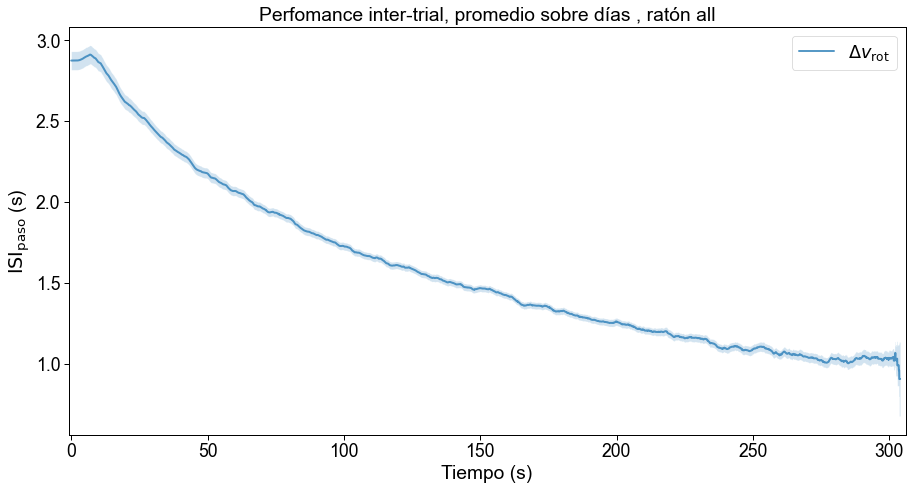

In [53]:
mouse = "all"
day = "all"
trial = "all"
x_key = "isi_dy_max"
plt.figure(figsize=(15, 7.5))
ref = stats_paw_avg[(mouse, day, trial)]
mu_isi = ref["mu_" + x_key].values / config.WAV_F_SAMPLING
sigma_isi = ref["sigma_" + x_key].values / config.WAV_F_SAMPLING
frames_isi = np.arange(len(mu_isi))
times_isi = frames_isi / config.WAV_F_SAMPLING
n_ventana = 11
v_rot = rotarod_tangential_speed(frames_isi) # en mm s-1
dot_v_rot = 45.0 / 300.0 * 0.5 * config.ROTAROD_HEIGHT * 2.0 * np.pi / 60.0 # en mm s-1
delta_v_rot = dot_v_rot * n_ventana * mu_isi
delta_v_rot_std = dot_v_rot * n_ventana * sigma_isi
porcentual_v_rot = dot_v_rot * n_ventana * mu_isi / v_rot * 100.0
porcentual_v_rot_std = dot_v_rot * n_ventana * sigma_isi / v_rot * 100.0

# plt.plot(times_isi, v_rot, alpha=0.75, lw=2, label=r"$v_{\mathrm{rot}}$")
plt.plot(times_isi, delta_v_rot, alpha=0.75, lw=2, label=r"$\Delta v_{\mathrm{rot}}$")
plt.fill_between(times_isi, delta_v_rot - delta_v_rot_std, delta_v_rot + delta_v_rot_std, alpha=0.2)

# plt.plot(times_isi, porcentual_v_rot, alpha=0.75, lw=2, label=r"$\frac{\Delta v_{\mathrm{rot}}}{v_{\mathrm{rot}}}$")
# plt.fill_between(times_isi, porcentual_v_rot - porcentual_v_rot_std, porcentual_v_rot + porcentual_v_rot_std, alpha=0.2)
# plt.hlines(10.0, 0, times_isi[-1], linestyles="dashed", label=r"$10\%$")
# t_10 = times_isi[np.argmin(np.abs(porcentual_v_rot - 10.0))]
# print(t_10)
# plt.arrow(t_10, 0, 0, 18, head_width=2, head_length=1, fc="k", ec="k")
# plt.text(t_10, 20, r"$t^{\mathrm{error}}_{10 \%} = $" + f"{t_10:.0f} s", ha="center", va="bottom", fontsize=14)

# plt.plot(times_isi, mu_isi, c="k", ls="--", alpha=0.75, lw=2, label=(mouse, day, trial))
# plt.fill_between(times_isi, mu_isi - sigma_isi, mu_isi + sigma_isi,  color="k", alpha=0.2)
plt.xlabel("Tiempo (s)")
plt.ylabel(r"$\mathrm{ISI}_{\mathrm{paso}}$ (s)")
# ylims = (20, 140) # isi_dy_max
# plt.ylim(*ylims)
# plt.xlim(-100, 30600) # frame
plt.xlim(-1, 306) # time
plt.legend()
plt.title(f"Perfomance inter-trial, promedio sobre días , ratón {mouse}")
plt.show()
plt.close()

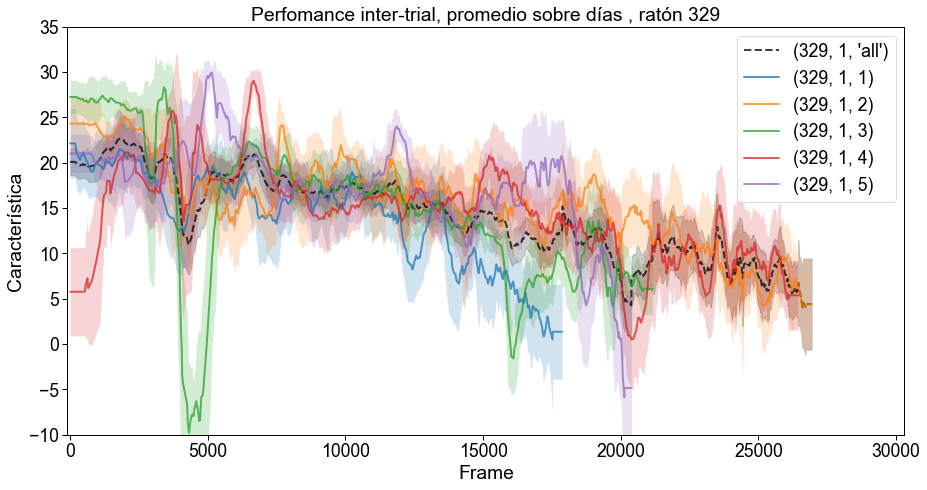

In [54]:
# mouse = 282 # Low performance
mouse = 329 # High performance
day = 1
# day = 5
# day = "all"
x_key = "y1"
ylims = (-10, 35) # y1
# x_key = "dy_max"
# ylims = (0, 600) # dy_max
# x_key = "amp"
# ylims = (-2, 40)  # amp
# x_key = "abs_delta_phi"
# ylims = (-0.05, 0.55) # abs_delta_phi
# x_key = "freq"
# ylims = (0.25, 4.5) # freq
plt.figure(figsize=(15, 7.5))
t = "all"
ref = stats_paw_avg[(mouse, day, t)]
mu_ref = ref["mu_" + x_key].values
sigma_ref = ref["sigma_" + x_key].values
times_ref = np.arange(len(mu_ref))
plt.plot(times_ref, mu_ref, c="k", ls="--", alpha=0.75, lw=2, label=(mouse, day, t))
plt.fill_between(times_ref, mu_ref - sigma_ref, mu_ref + sigma_ref,  color="k", alpha=0.2)
for t in config_dodo.TRIAL_LIST:
    stats = stats_paw_avg[(mouse, day, t)]
    mu = stats["mu_" + x_key].values
    sigma = stats["sigma_" + x_key].values
    times = np.arange(len(mu))
    plt.plot(times, mu, alpha=0.75, lw=2, label=(mouse, day, t))
    plt.fill_between(times, mu - sigma, mu + sigma, alpha=0.2)
plt.xlabel("Frame")
plt.ylabel("Característica")
plt.ylim(*ylims)
plt.xlim(-100, 30300) # frame
plt.legend()
plt.title(f"Perfomance inter-trial, promedio sobre días , ratón {mouse}")
plt.show()
plt.close()

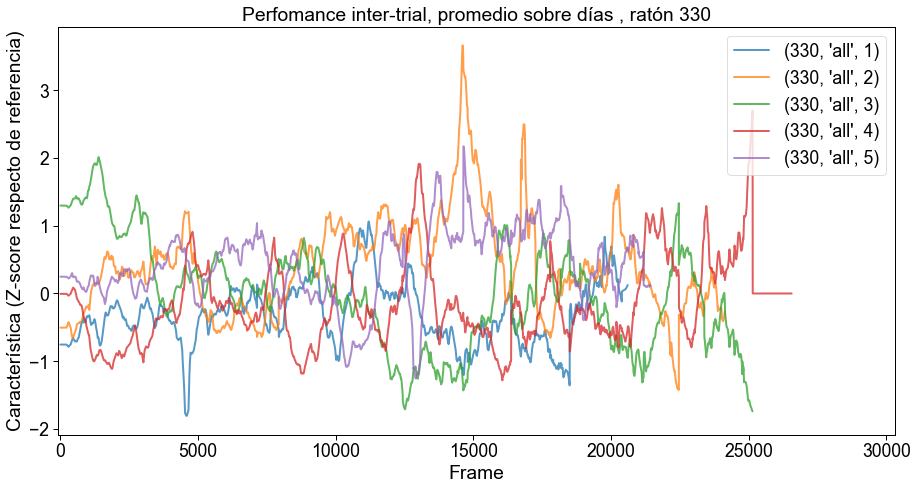

In [55]:
# mouse = 265 # High performance
# mouse = 297 # High performance
# mouse = 329 # High performance
# mouse = 282 # Low performance
mouse = 330 # Low performance
# day = 1
# day = 5
day = "all"
x_key = "y1"
# x_key = "dy_max"
# x_key = "amp"
# x_key = "abs_delta_phi"
# x_key = "freq"
plt.figure(figsize=(15, 7.5))
t = "all"
ref = stats_paw_avg[(mouse, day, t)]
mu_ref = ref["mu_" + x_key].values
sigma_ref = ref["sigma_" + x_key].values
for t in config_dodo.TRIAL_LIST:
    stats = stats_paw_avg[(mouse, day, t)]
    mu = stats["mu_" + x_key].values
    sigma = stats["sigma_" + x_key].values
    times = np.arange(len(mu))
    zscore = (mu - mu_ref[times]) / np.sqrt(sigma ** 2 + sigma_ref[times] ** 2)
    plt.plot(times, zscore, alpha=0.75, lw=2, label=(mouse, day, t))
plt.xlabel("Frame")
plt.ylabel("Característica (Z-score respecto de referencia)")
plt.xlim(-100, 30300) # frame
plt.legend()
plt.title(f"Perfomance inter-trial, promedio sobre días , ratón {mouse}")
plt.show()
plt.close()

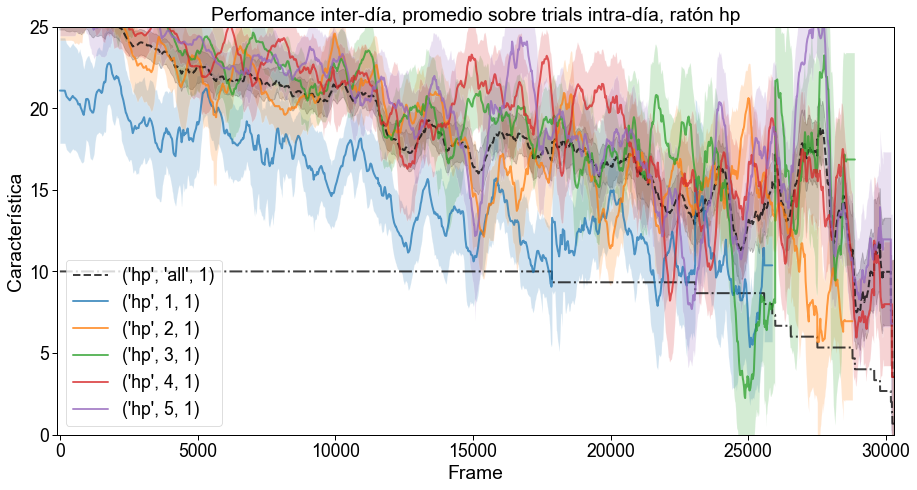

In [56]:
# mouse = 265 # High performance
# mouse = 297 # High performance
# mouse = 329 # High performance
# mouse = 262 # Low performance
# mouse = 263 # Low performance
# mouse = 264 # Low performance
# mouse = 282 # Low performance
# mouse = 295 # Low performance
# mouse = 298 # Low performance
# mouse = 330 # Low performance
# mouse = "all"
# mouse = "lp"
mouse = "hp"
trial = 1
# trial = 2
# trial = 3
# trial = 4
# trial = 5
# trial = "all"
x_key = "y1"
# ylims = (-10, 35) # y1
ylims = (0, 25) # y1 all mouse
# x_key = "dy_max"
# ylims = (0, 600) # dy_max
# x_key = "amp"
# ylims = (-2, 40)  # amp
# x_key = "abs_delta_phi"
# ylims = (-0.05, 0.55) # abs_delta_phi
# x_key = "freq"
# ylims = (0.25, 4.5) # freq
plt.figure(figsize=(15, 7.5))
d = "all"
ref = stats_paw_avg[(mouse, d, trial)]
mu_ref = ref["mu_" + x_key].values
sigma_ref = ref["sigma_" + x_key].values
times_ref = np.arange(len(mu_ref))
plt.plot(times_ref, mu_ref, c="k", ls="--", alpha=0.75, lw=2, label=(mouse, d, trial))
plt.fill_between(times_ref, mu_ref - sigma_ref, mu_ref + sigma_ref,  color="k", alpha=0.2)
n_ref = ref["n_trials"].values
n_ref = n_ref / n_ref.max() * 10
plt.plot(times_ref, n_ref, c="k", ls="-.", alpha=0.75, lw=2)
for d in config_dodo.DAY_LIST:
    stats = stats_paw_avg[(mouse, d, trial)]
    mu = stats["mu_" + x_key].values
    sigma = stats["sigma_" + x_key].values
    times = np.arange(len(mu))
    plt.plot(times, mu, alpha=0.75, lw=2, label=(mouse, d, trial))
    plt.fill_between(times, mu - sigma, mu + sigma, alpha=0.2)
plt.xlabel("Frame")
plt.ylabel("Característica")
plt.ylim(*ylims)
plt.xlim(-100, 30300) # frame
plt.legend()
plt.title(f"Perfomance inter-día, promedio sobre trials intra-día, ratón {mouse}")
plt.show()
plt.close()

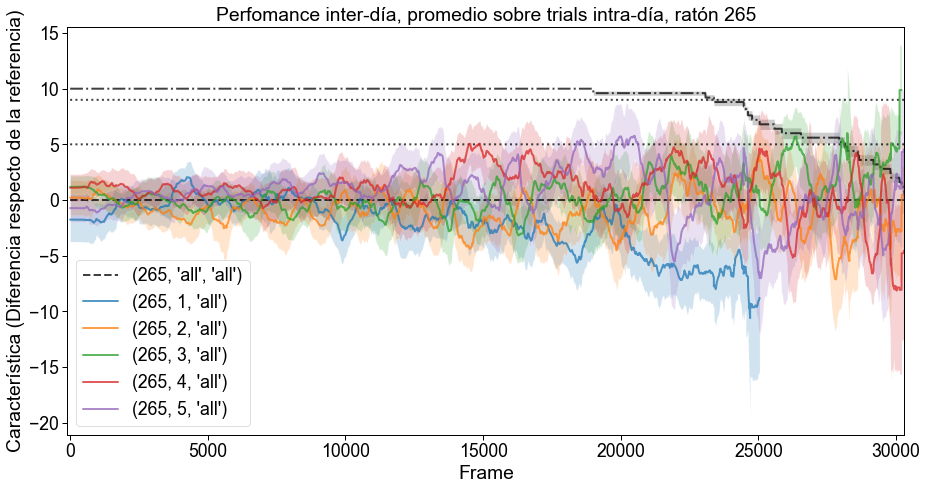

In [57]:
mouse = 265 # High performance
# mouse = 297 # High performance
# mouse = 329 # High performance
# mouse = 262 # Low performance
# mouse = 263 # Low performance
# mouse = 264 # Low performance
# mouse = 282 # Low performance
# mouse = 295 # Low performance
# mouse = 298 # Low performance
# mouse = 330 # Low performance
# mouse = "all"
# mouse = "lp"
# mouse = "hp"
trial = 1
trial = 2
trial = 3
trial = 4
trial = 5
trial = "all"
x_key = "y1"
# x_key = "dy_max"
# x_key = "amp"
# x_key = "abs_delta_phi"
# x_key = "freq"
plt.figure(figsize=(15, 7.5))
d = "all"
ref = stats_paw_avg[(mouse, d, trial)]
mu_ref = ref["mu_" + x_key].values
sigma_ref = ref["sigma_" + x_key].values
times_ref = np.arange(len(mu_ref))
plt.plot(times_ref, np.zeros_like(mu_ref), c="k", ls="--", alpha=0.75, lw=2, label=(mouse, d, trial))
n_ref = np.float_(ref["n_trials"].values)
# sigma_n_ref = np.sqrt(n_ref)
# sigma_n_ref = np.sqrt(np.maximum(n_ref * (n_ref.max() - n_ref), 1.0) / (n_ref.max() * n_ref))
sigma_n_ref = np.sqrt(n_ref * (n_ref.max() - n_ref)) / n_ref.max() # Standard error of the mean for Bernoulli variables
n_ref = n_ref / n_ref.max() * 10
sigma_n_ref = sigma_n_ref / n_ref.max() * 10 # Cuidado porque n_ref fue modificado!
plt.plot(times_ref, n_ref, c="k", ls="-.", alpha=0.75, lw=2)
plt.fill_between(times_ref, n_ref - sigma_n_ref, n_ref + sigma_n_ref, facecolor="k", alpha=0.2)
plt.plot(times_ref, np.full_like(n_ref, 9), c="k", ls="dotted", alpha=0.75, lw=2)
plt.plot(times_ref, np.full_like(n_ref, 5), c="k", ls="dotted", alpha=0.75, lw=2)
for d in config_dodo.DAY_LIST:
    stats = stats_paw_avg[(mouse, d, trial)]
    mu = stats["mu_" + x_key].values
    sigma = stats["sigma_" + x_key].values
    times = np.arange(len(mu))
    mu_dif = mu - mu_ref[times]
    sigma_dif = np.sqrt(sigma ** 2 + sigma_ref[times] ** 2)
    plt.plot(times, mu_dif, alpha=0.75, lw=2, label=(mouse, d, trial))
    plt.fill_between(times, mu_dif - sigma_dif, mu_dif + sigma_dif, alpha=0.2)
plt.xlabel("Frame")
plt.ylabel("Característica (Diferencia respecto de la referencia)")
plt.xlim(-100, 30300) # frame
plt.legend()
plt.title(f"Perfomance inter-día, promedio sobre trials intra-día, ratón {mouse}")
plt.show()
plt.close()

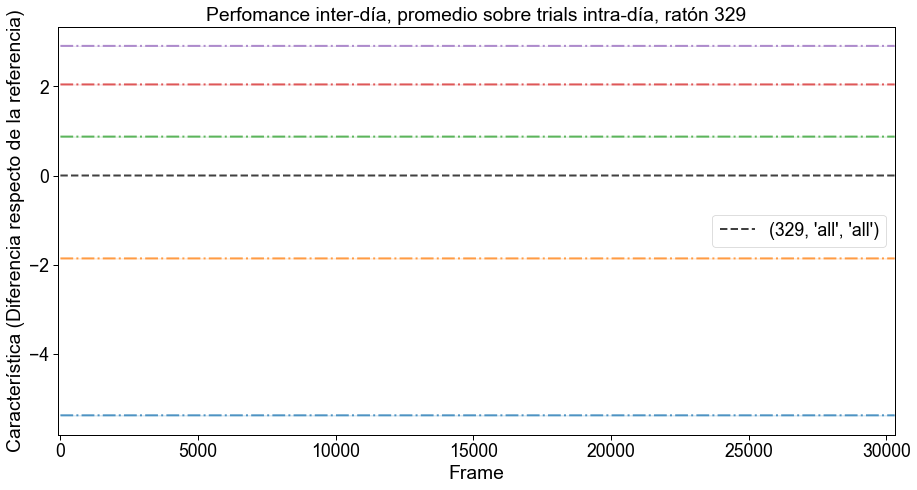

In [58]:
# mouse = 265 # High performance
# mouse = 297 # High performance
mouse = 329 # High performance
# mouse = 262 # Low performance
# mouse = 263 # Low performance
# mouse = 264 # Low performance
# mouse = 282 # Low performance
# mouse = 295 # Low performance
# mouse = 298 # Low performance
# mouse = 330 # Low performance
# mouse = "all"
# mouse = "lp"
# mouse = "hp"
# trial = 1
# trial = 2
# trial = 3
# trial = 5
trial = "all"
x_key = "y1"
# x_key = "dy_max"
# x_key = "amp"
# x_key = "abs_delta_phi"
# x_key = "freq"
plt.figure(figsize=(15, 7.5))
d = "all"
ref = stats_paw_avg[(mouse, d, trial)]
mu_ref = ref["mu_" + x_key].values
sigma_ref = ref["sigma_" + x_key].values
times_ref = np.arange(len(mu_ref))
plt.plot(times_ref, np.zeros_like(mu_ref), c="k", ls="--", alpha=0.75, lw=2, label=(mouse, d, trial))
n_ref = np.float_(ref["n_trials"].values)
for d in config_dodo.DAY_LIST:
    stats = stats_paw_avg[(mouse, d, trial)]
    mu = stats["mu_" + x_key].values
    sigma = stats["sigma_" + x_key].values
    times = np.arange(len(mu))
    mu_dif = mu - mu_ref[times]
    sigma_dif = np.sqrt(sigma ** 2 + sigma_ref[times] ** 2)
    # plt.plot(times, mu_dif, alpha=0.75, lw=2, label=(mouse, d, trial))
    # plt.fill_between(times, mu_dif - sigma_dif, mu_dif + sigma_dif, alpha=0.2)
    # weights = np.ones_like(sigma_dif)
    # weights = 1 / sigma_dif ** 2
    weights = n_ref[times]
    weights /= np.sum(weights)
    weighted_mean = np.sum(weights * mu_dif)
    weighted_std = np.sqrt(np.sum((weights * sigma_dif) ** 2))
    # weighted_mean = np.average(mu_dif[:15000], weights=weights[:15000])
    # weighted_std = np.sqrt(np.average(sigma_dif[:15000] ** 2, weights=weights[:15000] ** 2))
    plt.plot(times_ref, np.full_like(mu_ref, weighted_mean), ls="-.", alpha=0.75, lw=2)
    plt.fill_between(times_ref, np.full_like(mu_ref, weighted_mean - weighted_std), np.full_like(mu_ref, weighted_mean + weighted_std), alpha=0.2)
    # plt.plot(times_ref, np.full_like(mu_ref, weighted_mean / weighted_std), ls="-.", alpha=0.75, lw=2)
plt.xlabel("Frame")
plt.ylabel("Característica (Diferencia respecto de la referencia)")
plt.xlim(-100, 30300) # frame
plt.legend()
plt.title(f"Perfomance inter-día, promedio sobre trials intra-día, ratón {mouse}")
plt.show()
plt.close()

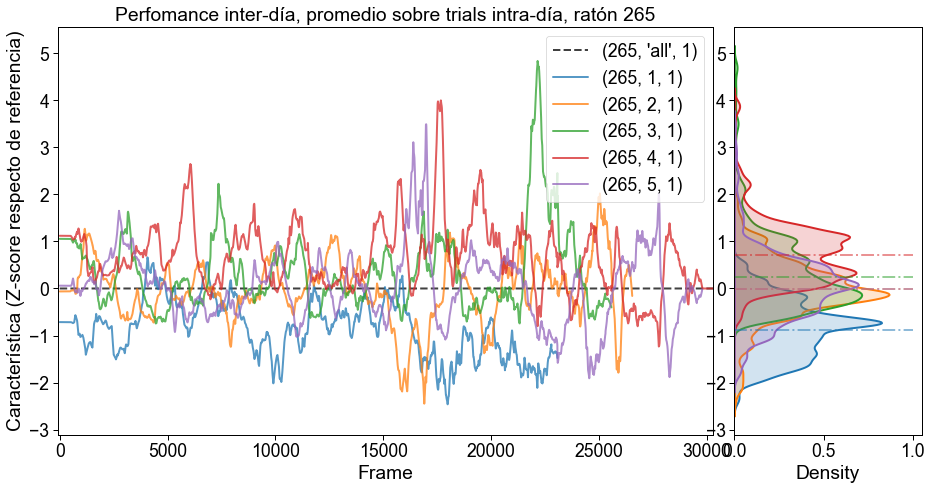

In [59]:
mouse = 265 # High performance
# mouse = 297 # High performance
# mouse = 329 # High performance
# mouse = 262 # Low performance
# mouse = 263 # Low performance
# mouse = 264 # Low performance
# mouse = 282 # Low performance
# mouse = 295 # Low performance
# mouse = 298 # Low performance
# mouse = 330 # Low performance
# mouse = "all"
# mouse = "lp"
# mouse = "hp"
trial = 1
# trial = 5
# trial = "all"
x_key = "y1"
# x_key = "dy_max"
# x_key = "amp"
# x_key = "abs_delta_phi"
# x_key = "freq"

fig = plt.figure(figsize=(15, 7.5))
gs = fig.add_gridspec(
    1, 2,  width_ratios=(7, 2),# height_ratios=(2, 7),
    left=0.1, right=0.9,# bottom=0.1, top=0.9,
    wspace=0.05,# hspace=0.05
)
ax = fig.add_subplot(gs[0])
ax_histy = fig.add_subplot(gs[1], sharey=ax)
t_max_compare = sorted([len(x) for x in [stats_paw_avg[(mouse, d, trial)]["mu_" + x_key] for d in config_dodo.DAY_LIST]])[1]
# t_max_short = 10000
# t_max_short = 12000
t_max_short = 15000
d = "all"
ref = stats_paw_avg[(mouse, d, trial)]
mu_ref = ref["mu_" + x_key].values
sigma_ref = ref["sigma_" + x_key].values
times_ref = np.arange(len(mu_ref))
ax.plot(times_ref, np.zeros_like(mu_ref), c="k", ls="--", alpha=0.75, lw=2, label=(mouse, d, trial))
zscores = []
for d in config_dodo.DAY_LIST:
    stats = stats_paw_avg[(mouse, d, trial)]
    mu = stats["mu_" + x_key].values
    sigma = stats["sigma_" + x_key].values
    times = np.arange(len(mu))
    zscore = (mu - mu_ref[times]) / np.sqrt(sigma ** 2 + sigma_ref[times] ** 2)
    zscores.append(zscore)
    ax.plot(times, zscore, alpha=0.75, lw=2, label=(mouse, d, trial))
    ax_histy.plot([0, 1], [trim_mean(zscore[:t_max_compare], proportiontocut=0.1)] * 2, lw=2, ls="-.", alpha=0.5)
    # ax_histy.plot([0, 1], [trim_mean(zscore[:t_max_short], proportiontocut=0.1)] * 2, lw=2, ls="dotted", alpha=0.5)
    # ax_histy.plot([0, 1], [np.mean(zscore[:t_max_compare])] * 2, lw=2, ls="-.", alpha=0.5)
    sns.kdeplot(y=zscore[:t_max_compare], fill=True, alpha=0.2, lw=2)
    # sns.kdeplot(y=zscore[:t_max_short], fill=True, alpha=0.2, lw=2)
# abs_zscore_sum = np.abs(get_variable_length_array(zscores)).sum(axis=-1) / len(zscores)
# ax.plot(abs_zscore_sum, "k", alpha=0.75, lw=2)
ax.set_xlabel("Frame")
ax.set_ylabel("Característica (Z-score respecto de referencia)")
# ax.ylim(-5, 5)
ax.set_xlim(-100, 30300) # frame
ax.legend()
ax.set_title(f"Perfomance inter-día, promedio sobre trials intra-día, ratón {mouse}")
plt.show()
plt.close()

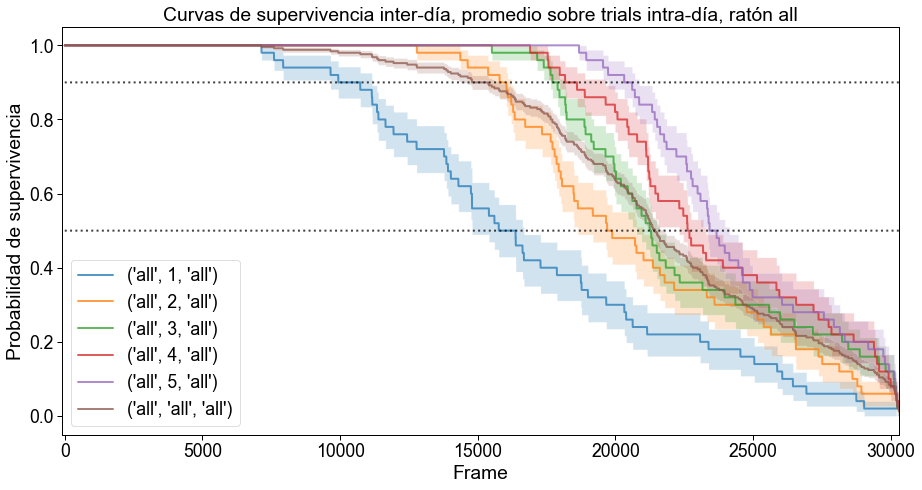

In [60]:
# mouse = 265 # High performance
# mouse = 297 # High performance
# mouse = 329 # High performance
# mouse = 262 # Low performance
# mouse = 263 # Low performance
# mouse = 264 # Low performance
# mouse = 282 # Low performance
# mouse = 295 # Low performance
# mouse = 298 # Low performance
# mouse = 330 # Low performance
mouse = "all"
# trial = 1
# trial = 2
# trial = 3
# trial = 4
# trial = 5
trial = "all"
plt.figure(figsize=(15, 7.5))
for d in config_dodo.DAY_LIST + ["all"]:
    ref = stats_paw_avg[(mouse, d, trial)]
    n_ref = np.float_(ref["n_trials"].values)
    n_ref_max = n_ref.max()
    # sigma_n_ref = np.sqrt(n_ref * (n_ref_max - n_ref)) / n_ref_max # Error estándar del promedio para variables Bernoulli
    sigma_n_ref = np.sqrt(n_ref * (n_ref_max - n_ref)  / n_ref_max) # Desviación estándar de una variable Binomial
    n_ref = n_ref / n_ref_max
    sigma_n_ref = sigma_n_ref / n_ref_max
    times_ref = np.arange(len(n_ref))
    plt.plot(times_ref, n_ref, alpha=0.75, lw=2, label=(mouse, d, trial))
    plt.fill_between(times_ref, n_ref - sigma_n_ref, n_ref + sigma_n_ref, alpha=0.2)
plt.plot(times_ref, np.full_like(n_ref, 0.9), c="k", ls="dotted", alpha=0.75, lw=2)
plt.plot(times_ref, np.full_like(n_ref, 0.5), c="k", ls="dotted", alpha=0.75, lw=2)
plt.xlabel("Frame")
plt.ylabel("Probabilidad de supervivencia")
plt.xlim(-100, 30300) # frame
plt.legend()
plt.title(f"Curvas de supervivencia inter-día, promedio sobre trials intra-día, ratón {mouse}")
plt.show()
plt.close()

[17213.50802851  5765.24857636]
[21313.18461759  4611.95241609]
[22713.63054366  3957.16004779]
[23887.86501296  4047.30452464]
[24508.73288701  3359.68493424]


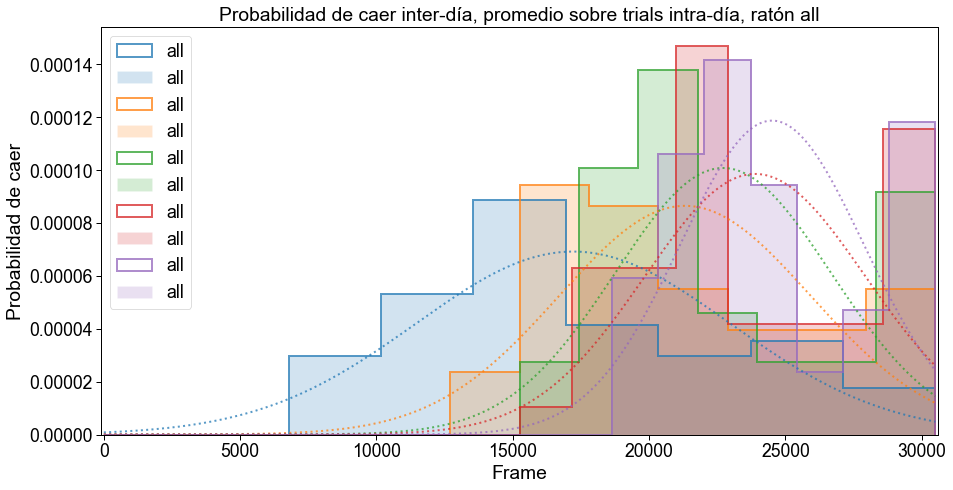

In [61]:
import importlib
importlib.reload(config_dodo)
from scipy.optimize import curve_fit
from scipy.stats import norm
def logistic_curve(t, a, b):
    """Logistic sigmoid curve."""
    return 1.0 / (1.0 + np.exp(-(t - a) / b))
logistic_curve = lambda t, a, b: norm.cdf(t, loc=a, scale=b)
mouse = 265 # High performance
mouse = 297 # High performance
mouse = 329 # High performance
mouse = 262 # Low performance
mouse = 263 # Low performance
mouse = 264 # Low performance
mouse = 282 # Low performance
# mouse = 295 # Low performance
# mouse = 298 # Low performance
# mouse = 330 # Low performance
mouse = "all"
# mouse = "lp"
# mouse = "hp"
# trial = 1
# trial = 2
# trial = 3
# trial = 4
# trial = 5
trial = "all"
plt.figure(figsize=(15, 7.5))
ax = plt.gca()
times = np.arange(0, 30500, dtype=float)
for d in config_dodo.DAY_LIST:
    ref = stats_paw_avg[(mouse, d, trial)]
    n_ref = np.float_(ref["n_trials"].values)
    n_ref_max = n_ref.max()
    n_ref = n_ref / n_ref_max
    sigma_n_ref = np.maximum(
        np.sqrt(n_ref * (1.0 - n_ref)) / n_ref_max, # Error estándar del promedio para variables Bernoulli
        np.sqrt(n_ref_max - 1) / n_ref_max ** 2
    )
    # sigma_n_ref = np.maximum(
    #     np.sqrt(n_ref * (1.0 - n_ref) / n_ref_max), # Desviación estándar de una variable Binomial
    #     np.sqrt(n_ref_max - 1) / n_ref_max ** 1.5
    # )
    n_ref = 1.0 - n_ref
    times_ref = np.arange(len(n_ref))
    prob = np.ones_like(times, dtype=float)
    # prob_std = np.full_like(times, np.sqrt(n_ref_max - 1) / n_ref_max ** 1.5, dtype=float)
    prob_std = np.full_like(times, np.sqrt(n_ref_max - 1) / n_ref_max ** 2, dtype=float)
    prob[:len(n_ref)] = n_ref
    prob_std[:len(n_ref)] = sigma_n_ref
    color = next(ax._get_lines.prop_cycler)['color']
    # plt.plot(times, prob, c=color, alpha=0.75, lw=2, label=(mouse, d, trial))
    # plt.fill_between(times, np.maximum(0.0, prob - prob_std), np.minimum(1.0, prob + prob_std), facecolor=color, alpha=0.2)
    popt, pcov = curve_fit(logistic_curve, times, prob, sigma=prob_std, absolute_sigma=True, p0=(20000.0, 0.25 * 5000.0), bounds=([0.0, 0.0], [np.inf, np.inf]))
    print(popt)
    # plt.plot(times, logistic_curve(times, *popt), c=color, ls="dotted", alpha=0.75, lw=2)
    plt.hist(latencies.query("day == @d")["latency"].values, bins="auto", range=(0, 30500), density=True, histtype="step", alpha=0.75, lw=2, color=color, label=(mouse, d, trial))
    plt.hist(latencies.query("day == @d")["latency"].values, bins="auto", range=(0, 30500), density=True, histtype="stepfilled", alpha=0.2, color=color, label=(mouse, d, trial))
    plt.plot(times, np.gradient(logistic_curve(times, *popt)), c=color, ls="dotted", alpha=0.75, lw=2)
# plt.plot(times, np.full_like(prob, 0.7), c="k", ls="dotted", alpha=0.75, lw=2)
plt.xlabel("Frame")
plt.ylabel("Probabilidad de caer")
plt.xlim(-100, 30600) # frame
plt.legend()
plt.title(f"Probabilidad de caer inter-día, promedio sobre trials intra-día, ratón {mouse}")
plt.show()
plt.close()

[13979.88857621  3488.29725458]
[18397.19819813  2550.61721401]
[20036.29867698  1956.08686624]
[21552.27579751  2584.11395216]
[22535.85044145  1935.91974223]


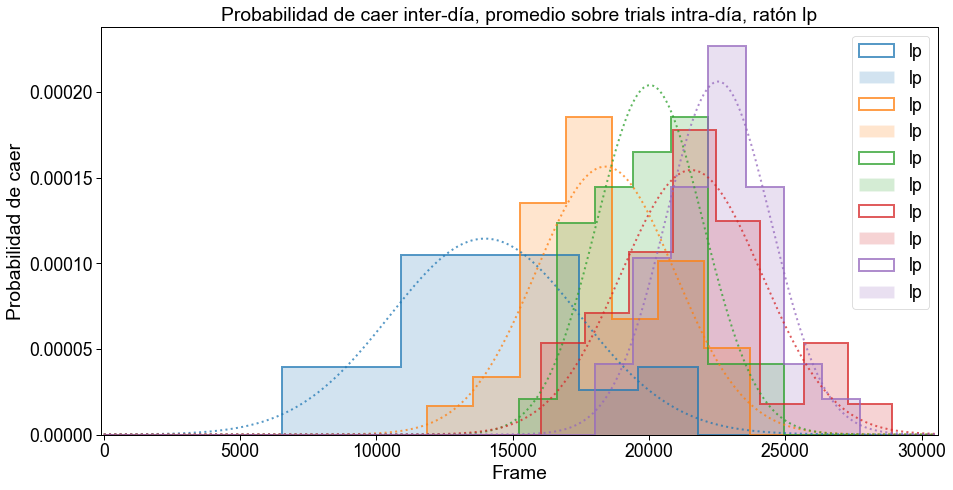

In [62]:
import importlib
importlib.reload(config_dodo)
from scipy.optimize import curve_fit
from scipy.stats import norm
def logistic_curve(t, a, b):
    """Logistic sigmoid curve."""
    return 1.0 / (1.0 + np.exp(-(t - a) / b))
logistic_curve = lambda t, a, b: norm.cdf(t, loc=a, scale=b)
mouse = 265 # High performance
mouse = 297 # High performance
mouse = 329 # High performance
mouse = 262 # Low performance
mouse = 263 # Low performance
mouse = 264 # Low performance
mouse = 282 # Low performance
# mouse = 295 # Low performance
# mouse = 298 # Low performance
# mouse = 330 # Low performance
# mouse = "all"
mouse = "lp"
# mouse = "hp"
# trial = 1
# trial = 2
# trial = 3
# trial = 4
# trial = 5
trial = "all"
plt.figure(figsize=(15, 7.5))
ax = plt.gca()
times = np.arange(0, 30500, dtype=float)
for d in config_dodo.DAY_LIST:
    ref = stats_paw_avg[(mouse, d, trial)]
    n_ref = np.float_(ref["n_trials"].values)
    n_ref_max = n_ref.max()
    n_ref = n_ref / n_ref_max
    sigma_n_ref = np.maximum(
        np.sqrt(n_ref * (1.0 - n_ref)) / n_ref_max, # Error estándar del promedio para variables Bernoulli
        np.sqrt(n_ref_max - 1) / n_ref_max ** 2
    )
    # sigma_n_ref = np.maximum(
    #     np.sqrt(n_ref * (1.0 - n_ref) / n_ref_max), # Desviación estándar de una variable Binomial
    #     np.sqrt(n_ref_max - 1) / n_ref_max ** 1.5
    # )
    n_ref = 1.0 - n_ref
    times_ref = np.arange(len(n_ref))
    prob = np.ones_like(times, dtype=float)
    # prob_std = np.full_like(times, np.sqrt(n_ref_max - 1) / n_ref_max ** 1.5, dtype=float)
    prob_std = np.full_like(times, np.sqrt(n_ref_max - 1) / n_ref_max ** 2, dtype=float)
    prob[:len(n_ref)] = n_ref
    prob_std[:len(n_ref)] = sigma_n_ref
    color = next(ax._get_lines.prop_cycler)['color']
    # plt.plot(times, prob, c=color, alpha=0.75, lw=2, label=(mouse, d, trial))
    # plt.fill_between(times, np.maximum(0.0, prob - prob_std), np.minimum(1.0, prob + prob_std), facecolor=color, alpha=0.2)
    popt, pcov = curve_fit(logistic_curve, times, prob, sigma=prob_std, absolute_sigma=True, p0=(20000.0, 0.25 * 5000.0), bounds=([0.0, 0.0], [np.inf, np.inf]))
    print(popt)
    # plt.plot(times, logistic_curve(times, *popt), c=color, ls="dotted", alpha=0.75, lw=2)
    plt.hist(latencies.query("mouse in @config_dodo.LP_MOUSE_LIST and day == @d")["latency"].values, bins="auto", range=(0, 30500), density=True, histtype="step", alpha=0.75, lw=2, color=color, label=(mouse, d, trial))
    plt.hist(latencies.query("mouse in @config_dodo.LP_MOUSE_LIST and day == @d")["latency"].values, bins="auto", range=(0, 30500), density=True, histtype="stepfilled", alpha=0.2, color=color, label=(mouse, d, trial))
    plt.plot(times, np.gradient(logistic_curve(times, *popt)), c=color, ls="dotted", alpha=0.75, lw=2)
plt.xlabel("Frame")
# plt.ylabel("Probabilidad de supervivencia")
plt.ylabel("Probabilidad de caer")
plt.xlim(-100, 30600) # frame
plt.legend()
# plt.title(f"Curvas de supervivencia inter-día, promedio sobre trials intra-día, ratón {mouse}")
plt.title(f"Probabilidad de caer inter-día, promedio sobre trials intra-día, ratón {mouse}")
plt.show()
plt.close()

[24561.40553333  3763.57998791]
[27663.03131689  1956.45689495]
[28843.23821612  1816.72812581]
[29084.26991275  1802.36059291]
[29200.74353176  1577.08432383]


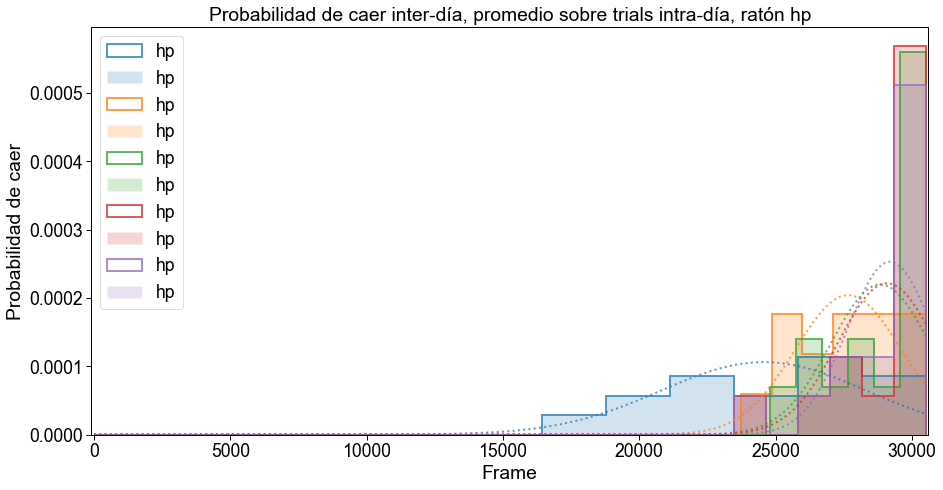

In [63]:
import importlib
importlib.reload(config_dodo)
from scipy.optimize import curve_fit
from scipy.stats import norm
def logistic_curve(t, a, b):
    """Logistic sigmoid curve."""
    return 1.0 / (1.0 + np.exp(-(t - a) / b))
logistic_curve = lambda t, a, b: norm.cdf(t, loc=a, scale=b)
mouse = 265 # High performance
mouse = 297 # High performance
mouse = 329 # High performance
mouse = 262 # Low performance
mouse = 263 # Low performance
mouse = 264 # Low performance
mouse = 282 # Low performance
# mouse = 295 # Low performance
# mouse = 298 # Low performance
# mouse = 330 # Low performance
# mouse = "all"
# mouse = "lp"
mouse = "hp"
# trial = 1
# trial = 2
# trial = 3
# trial = 4
# trial = 5
trial = "all"
plt.figure(figsize=(15, 7.5))
ax = plt.gca()
times = np.arange(0, 30500, dtype=float)
for d in config_dodo.DAY_LIST:
    ref = stats_paw_avg[(mouse, d, trial)]
    n_ref = np.float_(ref["n_trials"].values)
    n_ref_max = n_ref.max()
    n_ref = n_ref / n_ref_max
    sigma_n_ref = np.maximum(
        np.sqrt(n_ref * (1.0 - n_ref)) / n_ref_max, # Error estándar del promedio para variables Bernoulli
        np.sqrt(n_ref_max - 1) / n_ref_max ** 2
    )
    # sigma_n_ref = np.maximum(
    #     np.sqrt(n_ref * (1.0 - n_ref) / n_ref_max), # Desviación estándar de una variable Binomial
    #     np.sqrt(n_ref_max - 1) / n_ref_max ** 1.5
    # )
    n_ref = 1.0 - n_ref
    times_ref = np.arange(len(n_ref))
    prob = np.ones_like(times, dtype=float)
    # prob_std = np.full_like(times, np.sqrt(n_ref_max - 1) / n_ref_max ** 1.5, dtype=float)
    prob_std = np.full_like(times, np.sqrt(n_ref_max - 1) / n_ref_max ** 2, dtype=float)
    prob[:len(n_ref)] = n_ref
    prob_std[:len(n_ref)] = sigma_n_ref
    color = next(ax._get_lines.prop_cycler)['color']
    # plt.plot(times, prob, c=color, alpha=0.75, lw=2, label=(mouse, d, trial))
    # plt.fill_between(times, np.maximum(0.0, prob - prob_std), np.minimum(1.0, prob + prob_std), facecolor=color, alpha=0.2)
    popt, pcov = curve_fit(logistic_curve, times, prob, sigma=prob_std, absolute_sigma=True, p0=(20000.0, 0.25 * 5000.0), bounds=([0.0, 0.0], [np.inf, np.inf]))
    print(popt)
    # plt.plot(times, logistic_curve(times, *popt), c=color, ls="dotted", alpha=0.75, lw=2)
    plt.hist(latencies.query("mouse in @config_dodo.HP_MOUSE_LIST and day == @d")["latency"].values, bins="auto", range=(0, 30500), density=True, histtype="step", alpha=0.75, lw=2, color=color, label=(mouse, d, trial))
    plt.hist(latencies.query("mouse in @config_dodo.HP_MOUSE_LIST and day == @d")["latency"].values, bins="auto", range=(0, 30500), density=True, histtype="stepfilled", alpha=0.2, color=color, label=(mouse, d, trial))
    plt.plot(times, np.gradient(logistic_curve(times, *popt)), c=color, ls="dotted", alpha=0.75, lw=2)
plt.xlabel("Frame")
# plt.ylabel("Probabilidad de supervivencia")
plt.ylabel("Probabilidad de caer")
plt.xlim(-100, 30600) # frame
plt.legend()
# plt.title(f"Curvas de supervivencia inter-día, promedio sobre trials intra-día, ratón {mouse}")
plt.title(f"Probabilidad de caer inter-día, promedio sobre trials intra-día, ratón {mouse}")
plt.show()
plt.close()

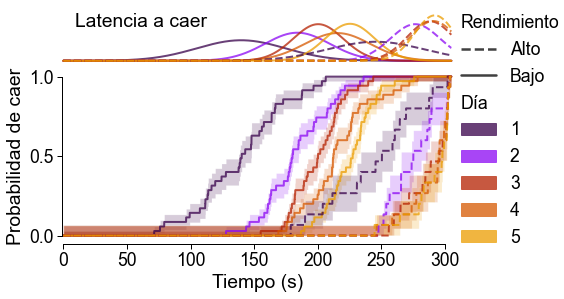

In [28]:
import importlib
importlib.reload(config_dodo)
from scipy.optimize import curve_fit
from scipy.stats import norm, chi2
from matplotlib.transforms import Bbox
def logistic_curve(t, a, b):
    """Logistic sigmoid curve."""
    return 1.0 / (1.0 + np.exp(-(t - a) / b))
logistic_curve = lambda t, a, b: norm.cdf(t, loc=a, scale=b)
# mouse = 265 # High performance
# mouse = 297 # High performance
# mouse = 329 # High performance
# mouse = 262 # Low performance
# mouse = 263 # Low performance
# mouse = 264 # Low performance
# mouse = 282 # Low performance
# mouse = 295 # Low performance
# mouse = 298 # Low performance
# mouse = 330 # Low performance
# mouse = "all"
mouse = "lp"
# mouse = "hp"
# trial = 1
# trial = 2
# trial = 3
# trial = 4
# trial = 5
trial = "all"
fig = plt.figure(figsize=(7, 4))
gs = fig.add_gridspec(
    2, 1, height_ratios=(2, 7), # width_ratios=(7, 2),
    bottom=0.1, top=0.9, # left=0.1, right=0.9,
    hspace=0.05, # wspace=0.05,
)
ax = fig.add_subplot(gs[1])
ax_histx = fig.add_subplot(gs[0], sharex=ax)
times = np.arange(0, 30500, dtype=float)
# color_days = dict(zip(config_dodo.DAY_LIST, plt.get_cmap("tab10")(np.linspace(0, 1, len(config_dodo.MOUSE_LIST)))))
color_days = dict(zip(config_dodo.DAY_LIST, plt.get_cmap("gnuplot")([0.05, 0.3, 0.5, 0.7, 0.85], len(config_dodo.DAY_LIST))))
for d in config_dodo.DAY_LIST:
    ref = stats_paw_avg[(mouse, d, trial)]
    n_ref = np.float_(ref["n_trials"].values)
    n_ref_max = n_ref.max()
    n_ref = n_ref / n_ref_max
    # sigma_n_ref = np.maximum(
    #     np.sqrt(n_ref * (1.0 - n_ref)) / n_ref_max, # Error estándar del promedio para variables Bernoulli
    #     np.sqrt(n_ref_max - 1) / n_ref_max ** 2
    # )
    sigma_n_ref = np.maximum(
        np.sqrt(n_ref * (1.0 - n_ref) / n_ref_max), # Desviación estándar de una variable Binomial
        np.sqrt(n_ref_max - 1) / n_ref_max ** 1.5
    )
    n_ref = 1.0 - n_ref
    times_ref = np.arange(len(n_ref))
    prob = np.ones_like(times, dtype=float)
    # prob_std = np.full_like(times, np.sqrt(n_ref_max - 1) / n_ref_max ** 2, dtype=float)
    prob_std = np.full_like(times, np.sqrt(n_ref_max - 1) / n_ref_max ** 1.5, dtype=float)
    prob[:len(n_ref)] = n_ref
    prob_std[:len(n_ref)] = sigma_n_ref
    color = next(ax._get_lines.prop_cycler)['color']
    ax.plot(times / 100, prob, c=color_days[d], alpha=0.75, lw=2, label=(mouse, d, trial))
    ax.fill_between(times / 100, np.maximum(0.0, prob - prob_std), np.minimum(1.0, prob + prob_std), facecolor=color_days[d], alpha=0.2)
    popt, pcov = curve_fit(logistic_curve, times, prob, sigma=prob_std, absolute_sigma=True, p0=(20000.0, 0.25 * 5000.0), bounds=([0.0, 0.0], [np.inf, np.inf]))
    # print(popt)
    """get error of parameters from covariance matrix pcov"""
    perr = np.sqrt(np.diag(pcov))
    # print(perr)
    """get mahalanobis distance and probability of the data, using prob, prob_std and times"""
    md = np.sum(((prob - logistic_curve(times, *popt)) / prob_std) ** 2)
    p = chi2.sf(md, len(times) - len(popt))
    # print(f"{p * 100.0:.2f}%")
    # ax.plot(times / 100, logistic_curve(times, *popt), c=color_days[d], ls="dotted", alpha=0.75, lw=2)
    ax_histx.plot(times / 100, np.gradient(logistic_curve(times, *popt)), c=color_days[d], alpha=0.75, lw=2)
ax.set_prop_cycle(None)
mouse = "hp"
for d in config_dodo.DAY_LIST:
    ref = stats_paw_avg[(mouse, d, trial)]
    n_ref = np.float_(ref["n_trials"].values)
    n_ref_max = n_ref.max()
    n_ref = n_ref / n_ref_max
    # sigma_n_ref = np.maximum(
    #     np.sqrt(n_ref * (1.0 - n_ref)) / n_ref_max, # Error estándar del promedio para variables Bernoulli
    #     np.sqrt(n_ref_max - 1) / n_ref_max ** 2
    # )
    sigma_n_ref = np.maximum(
        np.sqrt(n_ref * (1.0 - n_ref) / n_ref_max), # Desviación estándar de una variable Binomial
        np.sqrt(n_ref_max - 1) / n_ref_max ** 1.5
    )
    n_ref = 1.0 - n_ref
    times_ref = np.arange(len(n_ref))
    prob = np.ones_like(times, dtype=float)
    # prob_std = np.full_like(times, np.sqrt(n_ref_max - 1) / n_ref_max ** 2, dtype=float)
    prob_std = np.full_like(times, np.sqrt(n_ref_max - 1) / n_ref_max ** 1.5, dtype=float)
    prob[:len(n_ref)] = n_ref
    prob_std[:len(n_ref)] = sigma_n_ref
    color = next(ax._get_lines.prop_cycler)['color']
    ax.plot(times / 100, prob, c=color_days[d], ls="--", alpha=0.75, lw=2, label=(mouse, d, trial))
    ax.fill_between(times / 100, np.maximum(0.0, prob - prob_std), np.minimum(1.0, prob + prob_std), facecolor=color_days[d], alpha=0.2)
    popt, pcov = curve_fit(logistic_curve, times, prob, sigma=prob_std, absolute_sigma=True, p0=(20000.0, 0.25 * 5000.0), bounds=([0.0, 0.0], [np.inf, np.inf]))
    # print(popt)
    """get error of parameters from covariance matrix pcov"""
    perr = np.sqrt(np.diag(pcov))
    # print(perr)
    """get mahalanobis distance and probability of the data, using prob, prob_std and times"""
    md = np.sum(((prob - logistic_curve(times, *popt)) / prob_std) ** 2)
    p = chi2.sf(md, len(times) - len(popt))
    # print(f"{p * 100.0:.2f}%")
    # ax.plot(times / 100, logistic_curve(times, *popt), c=color_days[d], ls="-.", alpha=0.75, lw=2)
    ax_histx.plot(times / 100, np.gradient(logistic_curve(times, *popt)), c=color_days[d], ls="--", alpha=0.75, lw=2)
ax.set_xlabel("Tiempo (s)")
ax.set_ylabel("Probabilidad de caer")
ax.set_xlim(-1, 306) # frame
# ax.legend()
ax_histx.set_axis_off()
sns.despine(trim=True)
plt.gca().tick_params(bottom=True, left=True)
plt.figtext(0.15, 0.9, "Latencia a caer", ha="left", va="top")
handles = []
labels = []
title_1 = "Rendimiento"
title_2 = "Día"
handles += [Line2D([], [], color="none")]
labels += [title_1]
handles += [Line2D([], [], lw=2.5, ls=ls, c="k", alpha=0.75) for ls in ["--", "-"]]
labels += ["Alto", "Bajo"]
handles += [Line2D([], [], color="none")]
labels += [title_2]
# handles += [mpatches.Patch(color=color_days[d], alpha=0.5) for d in config_dodo.DAY_LIST]
handles += [mpatches.Patch(color=color_days[d], alpha=0.75) for d in config_dodo.DAY_LIST]
labels += [str(t) for t in config_dodo.DAY_LIST]
# leg = plt.legend(handles=handles, labels=labels, loc="upper left", bbox_to_anchor=(0.91, 1), frameon=False)
leg = plt.legend(handles=handles, labels=labels, loc="upper left", bbox_to_anchor=(0.98, 1.3), frameon=False)
for item, label in zip(leg.legendHandles, leg.texts):
    if label._text in [title_1, title_2]:
        width = item.get_window_extent(fig.canvas.get_renderer()).width
        label.set_ha("left")
        label.set_position((-1.4 * width, 0.0))
leg._legend_handle_box.width = 90.0
# ax.set_title(f"Probabilidad de caer inter-día, promedio sobre trials intra-día, ratón {mouse}")
# plt.savefig(config_dodo.FIG_PATH / "Metrics" / "probabilidad_caer_por_rendimiento.png", bbox_inches="tight", dpi=600)
# plt.savefig(config_dodo.FIG_PATH / "Metrics" / "probabilidad_caer_por_rendimiento.png", bbox_inches="tight", pad_inches=1, dpi=600)
plt.savefig(
    # config_dodo.FIG_PATH / "Metrics" / "probabilidad_caer_por_rendimiento.pdf",
    config_dodo.FIG_PATH / "Metrics" / "probabilidad_caer_por_rendimiento.png",
    bbox_inches=Bbox.from_bounds(0, -0.3, 8.5, 4),
    dpi=300
)
plt.show()
plt.close()

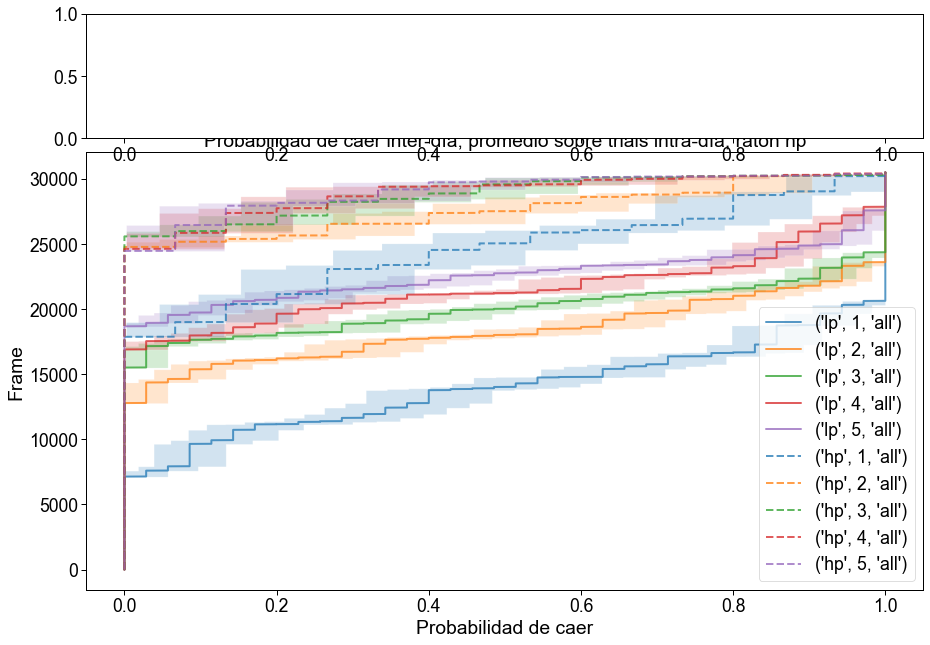

In [65]:
mouse = 265 # High performance
mouse = 297 # High performance
mouse = 329 # High performance
mouse = 262 # Low performance
mouse = 263 # Low performance
mouse = 264 # Low performance
mouse = 282 # Low performance
# mouse = 295 # Low performance
# mouse = 298 # Low performance
# mouse = 330 # Low performance
# mouse = "all"
mouse = "lp"
# mouse = "hp"
# trial = 1
# trial = 2
# trial = 3
# trial = 4
# trial = 5
trial = "all"
fig = plt.figure(figsize=(15, 10.0))
gs = fig.add_gridspec(
    2, 1, height_ratios=(2, 7), # width_ratios=(7, 2),
    bottom=0.1, top=0.9, # left=0.1, right=0.9,
    hspace=0.05, # wspace=0.05,
)
ax = fig.add_subplot(gs[1])
ax_histx = fig.add_subplot(gs[0], sharex=ax)
times = np.arange(0, 30500)
for d in config_dodo.DAY_LIST:# + ["all"]:
    prob = np.ones_like(times, dtype=float)
    prob_std = np.zeros_like(times, dtype=float)
    ref = stats_paw_avg[(mouse, d, trial)]
    n_ref = np.float_(ref["n_trials"].values)
    n_ref_max = n_ref.max()
    n_ref = n_ref / n_ref_max
    # sigma_n_ref = np.sqrt(n_ref * (1.0 - n_ref)) / n_ref_max # Error estándar del promedio para variables Bernoulli
    sigma_n_ref = np.sqrt(n_ref * (1.0 - n_ref)  / n_ref_max) # Desviación estándar de una variable Binomial
    n_ref = 1.0 - n_ref
    times_ref = np.arange(len(n_ref))
    prob[:len(n_ref)] = n_ref
    prob_std[:len(n_ref)] = sigma_n_ref
    # plt.plot(times_ref, n_ref, alpha=0.75, lw=2, label=(mouse, d, trial))
    # plt.fill_between(times_ref, n_ref - sigma_n_ref, n_ref + sigma_n_ref, alpha=0.2)
    ax.plot(prob, times, alpha=0.75, lw=2, label=(mouse, d, trial))
    ax.fill_betweenx(times, prob - prob_std, prob + prob_std, alpha=0.2)
ax.set_prop_cycle(None)
mouse = "hp"
for d in config_dodo.DAY_LIST:# + ["all"]:
    prob = np.ones_like(times, dtype=float)
    prob_std = np.zeros_like(times, dtype=float)
    ref = stats_paw_avg[(mouse, d, trial)]
    n_ref = np.float_(ref["n_trials"].values)
    n_ref_max = n_ref.max()
    n_ref = n_ref / n_ref_max
    # sigma_n_ref = np.sqrt(n_ref * (1.0 - n_ref)) / n_ref_max # Error estándar del promedio para variables Bernoulli
    sigma_n_ref = np.sqrt(n_ref * (1.0 - n_ref)  / n_ref_max) # Desviación estándar de una variable Binomial
    n_ref = 1.0 - n_ref
    times_ref = np.arange(len(n_ref))
    prob[:len(n_ref)] = n_ref
    prob_std[:len(n_ref)] = sigma_n_ref
    # plt.plot(times_ref, n_ref, alpha=0.75, lw=2, label=(mouse, d, trial))
    # plt.fill_between(times_ref, n_ref - sigma_n_ref, n_ref + sigma_n_ref, alpha=0.2)
    ax.plot(prob, times, ls="--", alpha=0.75, lw=2, label=(mouse, d, trial))
    ax.fill_betweenx(times, prob - prob_std, prob + prob_std, alpha=0.2)
# ax.plot(times, np.full_like(prob, 1.0), c="k", ls="dotted", alpha=0.75, lw=2)
# ax.plot(times, np.full_like(prob, 0.9), c="k", ls="dotted", alpha=0.75, lw=2)
# ax.plot(times, np.full_like(prob, 0.7), c="k", ls="dotted", alpha=0.75, lw=2)
# ax.plot(times, np.full_like(prob, 0.5), c="k", ls="dotted", alpha=0.75, lw=2)
ax.set_ylabel("Frame")
# ax.set_ylabel("Probabilidad de supervivencia")
ax.set_xlabel("Probabilidad de caer")
# ax.set_xlim(-100, 30600) # frame
ax.legend()
# ax.set_title(f"Curvas de supervivencia inter-día, promedio sobre trials intra-día, ratón {mouse}")
ax.set_title(f"Probabilidad de caer inter-día, promedio sobre trials intra-día, ratón {mouse}")
plt.show()
plt.close()